# Random Forest Model Analysis
### Analysis of Ezafe Classification Results

*Author: Raha Musavi*

*Matrikelnummer: 08022255354*

*Thesis: Modeling the Presence and the Classification of Ezafe in Middle Persian Nominal Phrases*

*Date: 01 May 2025*

This notebook provides a detailed analysis of the trained Random Forest model for classifying nominal phrases based on the presence of Ezafe and the syntactic position of the head of the nominal phrase in Middle Persian. It serves as the empirical support for the methodology, results, and discussion presented in **Chapter 6: Classification of Ezafe** of this thesis.

The analyses documented here cover:

*   **Data Preprocessing:** Steps taken to prepare the linguistic data for the model, including feature selection and encoding (Sections 6.1, 6.3, 6.4).
*   **Hyperparameter Tuning Results:** Optimal parameters obtained for the model configuration (Section 6.6, Table 19).
*   **Model Evaluation:** Performance assessment using standard classification metrics (Precision, Recall, F1-score), Confusion Matrix, and Receiver Operating Characteristic (ROC) analysis (Sections 6.9, 6.9.1, 6.10, Table 20, Figure 23, Figure 25).
*   **Model Validation:** Checks for robust learning using a Learning Curve and Random Label Shuffling test (Sections 6.10.2, 6.10.5, Figure 26).
*   **Feature Importance Analysis:** Examination of feature contributions using Gini importance, Permutation Importance, and SHAP values (Sections 6.4.1, 6.10, Figures 19, 20, 21, Table 18).
*   **Partial Dependence Analysis:** Interpretation of how key features influence model predictions through Partial Dependence Plots (Section 6.10.3, Figures 27, 28, 29, 31).
*   **Error Analysis:** Investigation of misclassification patterns and feature associations with errors (Section 6.10.6, Table 21).

The results presented herein reflect the final model configuration and evaluation discussed in Chapter 6, aiming to provide a comprehensive and transparent view of the classification task's outcome. 

Model classes: [0 1 2 3]
Feature dtypes:
 nominal_head_upos              int64
nominal_head_deprel            int64
head_number                    int64
head_frequency                 int64
dependent_frequency            int64
modifier_to_head_ratio       float64
dependent_upos                 int64
dependent_deprel               int64
distance                     float64
num_nouns_before               int64
num_adjs_before                int64
num_adjs_after                 int64
np_depth                       int64
num_dependents_head            int64
num_dependents_dependent       int64
is_verbal                      int64
relative_position_in_sent    float64
np_deprel_pattern              int64
source_file                    int64
dtype: object


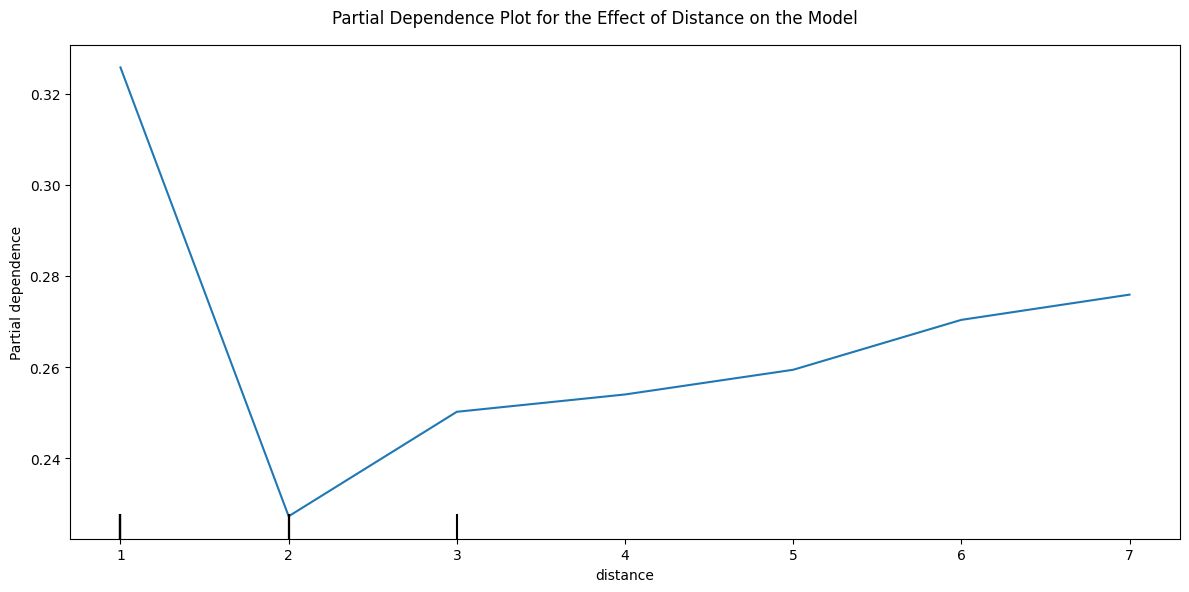

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder # Used for encoding categorical features

# --- Load Model and Data ---
# Load the trained Random Forest model and the dataset containing features.
# The combined target LabelEncoder is also loaded to understand the mapping between
# numerical indices and human-readable class labels.
best_model = joblib.load('random_forest_bestmodel.pkl')
le_combined = joblib.load('label_encoder_combined.pkl') # Loaded to understand target classes
df = pd.read_csv("rf_inputs.csv")

# --- Data Preprocessing for Features ---
# Apply the same preprocessing steps used before training the model (Section 6.1, 6.3, 6.4).
# Categorical features are transformed into numerical format using LabelEncoder.
# Note on Thesis Consistency (Dependency Encoding): Section 6.4 of the thesis describes
# dependency relations being transformed into embeddings; however, the actual implementation
# used to train this loaded model processed these features using Label Encoding. This notebook's
# analysis is based on the implementation details of the trained model, specifically
# using Label Encoding for these features as reflected in the data preparation below.
categorical_cols = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                    'np_deprel_pattern', 'head_number', 'source_file', 'nominal_head_upos',
                    'dependent_form', 'nominal_head_form']

# Initialize and apply Label Encoding to the specified categorical columns, handling missing values.
# This ensures the data format matches the model's expectations based on how it was trained.
label_encoders = {} # Store encoders for potential future use (e.g., decoding)
for col in categorical_cols:
    if col in df.columns: # Check if column exists before processing
        df[col] = df[col].astype(str).fillna("unknown") # Convert to string and fill NaNs
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col]) # Fit and transform
        label_encoders[col] = le # Store the fitted encoder
    else:
        # print(f"Warning: Categorical column '{col}' not found in dataframe during preprocessing.") # Keep or remove based on preference
        pass


# --- Select Features for Model Input (X) ---
# Create the feature matrix 'X' using only the columns that the loaded model was trained on.
# Using 'best_model.feature_names_in_' guarantees the feature set and their order match the model's expectation.
# Exclude ID and form columns which are identifiers, not features for prediction (Table 12, p. 59).
# Note: 'ezafe_label' and 'position' are target variables, excluded from features (Section 6.4).
feature_columns = [col for col in best_model.feature_names_in_ if col in df.columns]
X = df[feature_columns].copy() # Use .copy() to avoid SettingWithCopyWarning

# Ensure all features are numeric after selection, filling any remaining NaNs.
# This is a standard data cleaning step for numerical models.
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(-1) # Convert and fill potential NaNs


# --- Display Model Information and Feature Types ---
# Output information about the model's expected output classes and the prepared feature data types.
# This confirms the numerical encoding of features and the multi-class nature of the target.
print("Model classes:", best_model.classes_)
print("Feature dtypes:\n", X.dtypes)
print("Combined target class mapping:", dict(zip(le_combined.classes_, le_combined.transform(le_combined.classes_))))


# --- Generate and Plot Partial Dependence Plot (PDP) for 'distance' ---
# Generate the Partial Dependence Plot for the 'distance' feature.
# This plot visualizes the marginal effect of 'distance' on the model's output function.
# For multi-class models when no specific target is provided, PartialDependenceDisplay plots
# the average predicted probability across all classes. This presentation aligns with
# Figure 27 in the thesis (Section 6.10.3, p. 73) and its interpretation regarding the
# overall effect of distance on the model's averaged output.
fig, ax = plt.subplots(figsize=(12, 6))

PartialDependenceDisplay.from_estimator(
    estimator=best_model,    # The trained Random Forest model
    X=X,                     # The preprocessed feature dataset
    features=['distance'],   # The specific feature for which to plot the PDP
    ax=ax                    # The matplotlib axes to draw the plot on
    # No 'target' parameter is specified, plotting average dependence across classes, matching Figure 27.
)

# --- Customize and Display Plot ---
# Set informative titles and axis labels for the plot, linking it to the thesis.
plt.suptitle("Partial Dependence Plot for the Effect of Distance on the Model") # Descriptive main title
# Subtitle references the corresponding figure and section in the thesis text.
plt.title("As shown in Figure 27 (Section 6.10.3)", fontsize=10)
plt.xlabel("distance")       # Label for the x-axis, indicating the feature
plt.ylabel("Partial dependence") # Label for the y-axis, matching Figure 27 in appearance

# Adjust the plot layout to prevent elements from overlapping.
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle

# Display the generated plot.
plt.show()

Model classes: [0 1 2 3]
Feature dtypes:
 nominal_head_upos              int64
nominal_head_deprel            int64
head_number                    int64
head_frequency                 int64
dependent_frequency            int64
modifier_to_head_ratio       float64
dependent_upos                 int64
dependent_deprel               int64
distance                     float64
num_nouns_before               int64
num_adjs_before                int64
num_adjs_after                 int64
np_depth                       int64
num_dependents_head            int64
num_dependents_dependent       int64
is_verbal                      int64
relative_position_in_sent    float64
np_deprel_pattern              int64
source_file                    int64
dtype: object


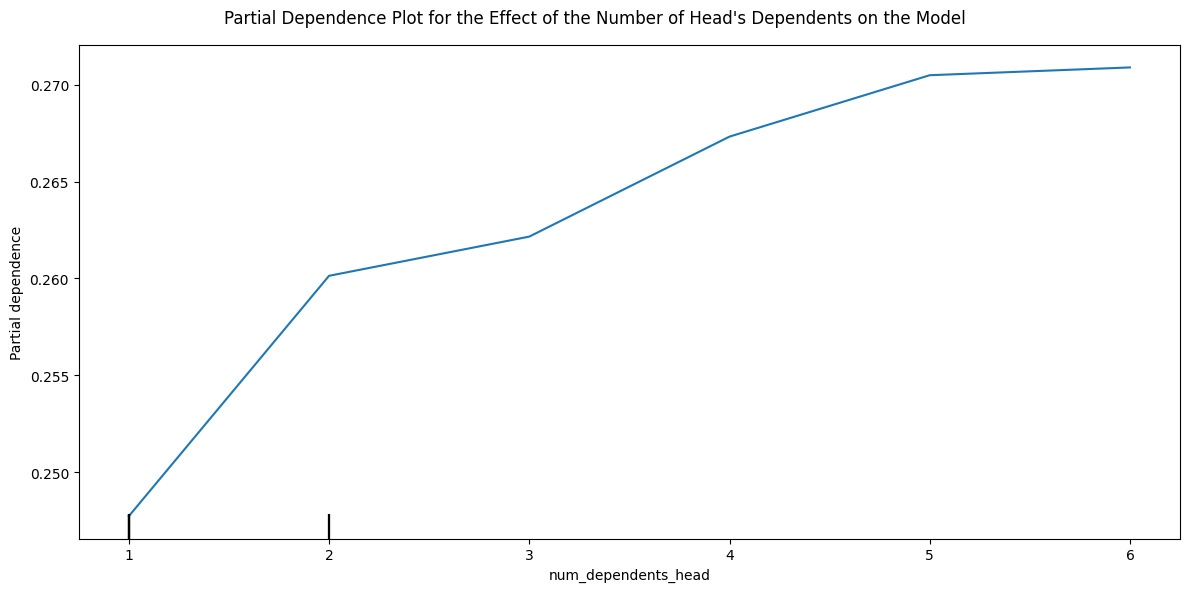

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder for preprocessing

# --- Load Model and Data ---
best_model = joblib.load('random_forest_bestmodel.pkl') # Load the specified model file
le_combined = joblib.load('label_encoder_combined.pkl') # Load the target label encoder
df = pd.read_csv("rf_inputs.csv") # Load the dataset

# --- Data Preprocessing for Features ---
# This block prepares the feature data by applying the same encoding steps
# used before training the model. Categorical features must be transformed into
# numerical representations for compatibility with the machine learning model
# (Section 6.4). This ensures the data for the PDP calculation matches
# the format expected by the model.
# The categorical columns include morphosyntactic properties, dependency patterns,
# and text properties as listed in Tables 13, 14, and 17 (pp. 59-61).
categorical_cols = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                    'np_deprel_pattern', 'head_number', 'source_file', 'nominal_head_upos',
                    'dependent_form', 'nominal_head_form']

# Initialize LabelEncoders and apply them to the specified categorical columns.
label_encoders = {col: LabelEncoder() for col in categorical_cols if col in df.columns}

for col in label_encoders:
    # Ensure columns are treated as strings and fill potential missing values,
    # consistent with preprocessing steps (Section 6.1).
    df[col] = df[col].astype(str).fillna("unknown")
    # Fit the encoder on the column data and transform it into numerical labels.
    df[col] = label_encoders[col].fit_transform(df[col])

# --- Select Features for Model Input (X) ---
# Create the feature matrix 'X' using only the columns that the
# loaded model was trained on. The 'best_model.feature_names_in_' attribute
# provides the list of feature names the model expects, ensuring consistency
# between the training data features and the data used for plotting.
X = df[[col for col in best_model.feature_names_in_ if col in df.columns]]

# --- Display Model Information and Feature Types (Original Prints) ---
# These print statements output key information about the model and the prepared data.
# "Model classes" shows the numerical indices representing the combined target labels
# that the model is trained to predict.
# "Feature dtypes" displays the data type of each column in the feature matrix X,
# confirming that categorical features have been successfully converted to numerical types.
print("Model classes:", best_model.classes_)
print("Feature dtypes:\n", X.dtypes)

# --- Generate Partial Dependence Plot (PDP) ---
# This section generates the Partial Dependence Plot (PDP) for the
# 'num_dependents_head' feature. A PDP illustrates how the model's prediction
# changes on average as the value of the selected feature varies, holding
# the effects of other features constant.
# 'num_dependents_head' is a Complexity Indicator feature (Table 14, p. 60)
# representing the count of immediate dependents attached to the head.
# This specific PDP is analyzed in Section 6.10.3 (p. 74) and visualized in Figure 29 (p. 74).

# Create the plot figure and axes for the PDP.
fig, ax = plt.subplots(figsize=(12, 6))

# Generate the Partial Dependence Plot for the 'num_dependents_head' feature.
# The 'features' parameter specifies the feature for which the PDP is calculated.
# The 'target=0' parameter indicates that the PDP is calculated for the model's
# prediction probability of the class represented by index 0 in the combined
# target labels (see le_combined.classes_ output).
PartialDependenceDisplay.from_estimator(
    estimator=best_model, # The trained Random Forest model
    X=X,                   # The feature dataset
    features=['num_dependents_head'], # The feature for the PDP
    target=0,              # Specify the target class index (0 in this case)
    ax=ax,                 # The matplotlib axes to draw on
    response_method='predict_proba' # Plot the dependence on the predicted probability of the target class
)

# --- Customize and Display Plot ---
# Set the main title for the plot, clearly stating the feature being analyzed.
plt.suptitle(f"Partial Dependence Plot for the Effect of the Number of Head's Dependents on the Model")
# A subtitle references the corresponding figure and section in the thesis text
# where this plot is discussed.
plt.title("As shown in Figure 29 (Section 6.10.3)", fontsize=10)
# Set the x-axis label to the name of the feature being plotted.
plt.xlabel("num_dependents_head")
# Set the y-axis label to indicate what the PDP value represents.
# Since response_method='predict_proba' is used, it shows the partial dependence
# on the probability of the target class.
target_class_name = le_combined.classes_[0] # Get the actual name of class 0
plt.ylabel(f"Partial Dependence (Predicted Probability of '{target_class_name}')")


# Adjust the plot layout to prevent elements from overlapping.
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the generated plot.
plt.show()



Model classes: [0 1 2 3]
Feature dtypes:
 nominal_head_upos              int64
nominal_head_deprel            int64
head_number                    int64
head_frequency                 int64
dependent_frequency            int64
modifier_to_head_ratio       float64
dependent_upos                 int64
dependent_deprel               int64
distance                     float64
num_nouns_before               int64
num_adjs_before                int64
num_adjs_after                 int64
np_depth                       int64
num_dependents_head            int64
num_dependents_dependent       int64
is_verbal                      int64
relative_position_in_sent    float64
np_deprel_pattern              int64
source_file                    int64
dtype: object


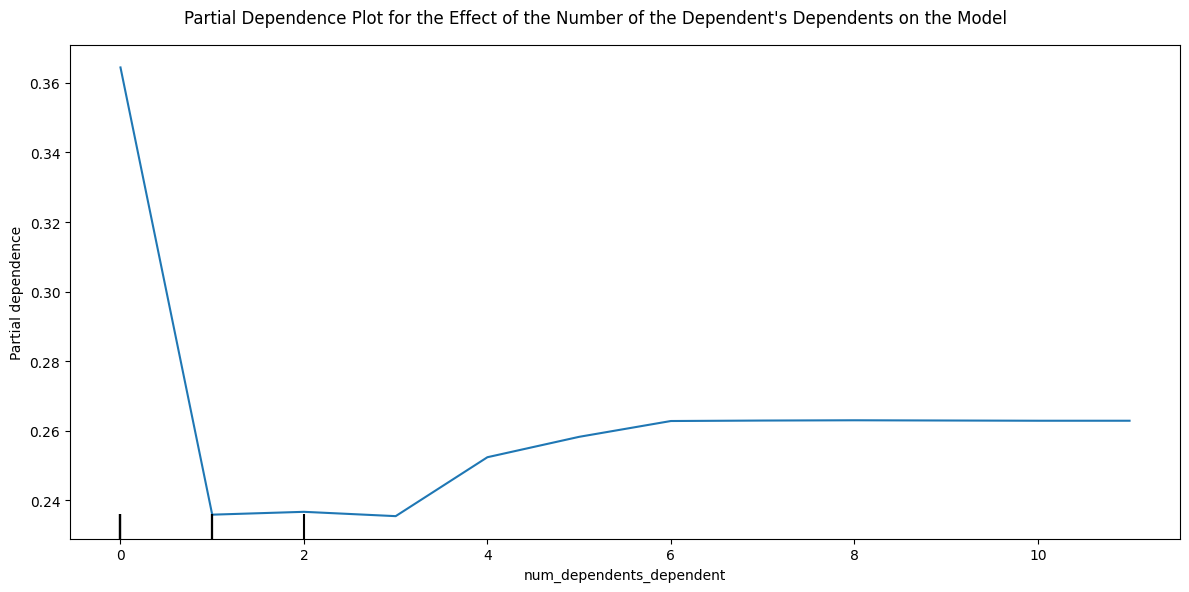

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder for preprocessing

# --- Load Model and Data ---
best_model = joblib.load('random_forest_bestmodel.pkl')
le_combined = joblib.load('label_encoder_combined.pkl')
df = pd.read_csv("rf_inputs.csv")

# --- Data Preprocessing for Features ---
# This block replicates the preprocessing steps applied to the features before
# training the model. Categorical features, which are non-numerical, need to be
# encoded into a numerical format that the machine learning model can process (Section 6.4).
# The columns listed here are those identified as categorical features, including
# morphosyntactic tags, dependency relations, and others (Tables 13, 14, 17).
# Handling of missing values is also included, as mentioned in Section 6.1.
categorical_cols = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                    'np_deprel_pattern', 'head_number', 'source_file', 'nominal_head_upos',
                    'dependent_form', 'nominal_head_form']

# Initialize LabelEncoders for the categorical columns found in the dataframe.
label_encoders = {col: LabelEncoder() for col in categorical_cols if col in df.columns}

for col in label_encoders:
    # Convert the column to string type and fill any missing values with 'unknown'.
    # This prevents errors during encoding and is consistent with preprocessing (Section 6.1).
    df[col] = df[col].astype(str).fillna("unknown")
    # Fit the encoder on the unique values in the column and transform the column
    # to replace string labels with numerical indices.
    df[col] = label_encoders[col].fit_transform(df[col])

# --- Select Features for Model Input (X) ---
# Create the feature matrix 'X' for model input. This matrix must contain
# the same features, in the same order, that the model was trained on.
# 'best_model.feature_names_in_' provides the exact list of feature names
# the model expects based on its training data.
# Features are extracted and defined in Section 6.3 and Tables 12-17 (pp. 59-61).
X = df[[col for col in best_model.feature_names_in_ if col in df.columns]]

# --- Display Model Information and Feature Types (Original Prints) ---
# These print statements are part of the original script's output.
# "Model classes" lists the numerical representations of the target classes
# that the model is designed to predict.
# "Feature dtypes" shows the data type of each column in the prepared
# feature matrix X, confirming that all features are in a numerical format
# suitable for the model.
print("Model classes:", best_model.classes_)
print("Feature dtypes:\n", X.dtypes)

# --- Generate Partial Dependence Plot (PDP) ---
# This section generates a Partial Dependence Plot (PDP) for the feature
# 'num_dependents_dependent'. A PDP illustrates the average effect of a
# single feature on the model's prediction, marginalizing over the values
# of all other features.
# 'num_dependents_dependent' is a Complexity Indicator feature (Table 14, p. 60)
# that counts the immediate dependents of the *dependent* noun/element.
# This specific PDP is analyzed in Section 6.10.3 (p. 73) and visualized in Figure 28 (p. 74).

# Create the plot figure and axes object using matplotlib.
fig, ax = plt.subplots(figsize=(12, 6))

# Generate the Partial Dependence Plot for the specified feature.
# The 'features' parameter indicates that the plot is for 'num_dependents_dependent'.
# The 'target=0' parameter specifies that the PDP calculates the effect on the
# model's prediction probability for the class with numerical index 0 in the
# combined target variable (refer to le_combined.classes_ to see which class this is).
# 'response_method='predict_proba'' is used to show the dependence on class probability.
PartialDependenceDisplay.from_estimator(
    estimator=best_model, # The trained machine learning model
    X=X,                   # The feature dataset
    features=['num_dependents_dependent'], # The feature for which to calculate dependence
    target=0,              # Calculate dependence for the target class with index 0
    ax=ax,                 # The matplotlib axes object to draw the plot on
    response_method='predict_proba' # Use predicted probabilities for the y-axis scale
)

# --- Customize and Display Plot ---
# Set the plot title using suptitle, providing a descriptive heading for the plot.
plt.suptitle(f"Partial Dependence Plot for the Effect of the Number of the Dependent's Dependents on the Model")
# Add a subtitle that references the corresponding figure and discussion in the thesis text.
plt.title("As shown in Figure 28 (Section 6.10.3)", fontsize=10)
# Set the x-axis label to clearly identify the feature whose effect is plotted.
plt.xlabel("num_dependents_dependent")
# Set the y-axis label to indicate what the PDP value represents.
# Get the name of the target class corresponding to index 0 for clarity in the label.
target_class_name = le_combined.classes_[0]
plt.ylabel(f"Partial Dependence (Predicted Probability of '{target_class_name}')")

# Adjust the plot layout to ensure all elements, including titles and labels, are visible.
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the generated plot window.
plt.show()



Model classes: [0 1 2 3]
Feature dtypes:
 nominal_head_upos              int64
nominal_head_deprel            int64
head_number                    int64
head_frequency                 int64
dependent_frequency            int64
modifier_to_head_ratio       float64
dependent_upos                 int64
dependent_deprel               int64
distance                     float64
num_nouns_before               int64
num_adjs_before                int64
num_adjs_after                 int64
np_depth                       int64
num_dependents_head            int64
num_dependents_dependent       int64
is_verbal                      int64
relative_position_in_sent    float64
np_deprel_pattern              int64
source_file                    int64
dtype: object


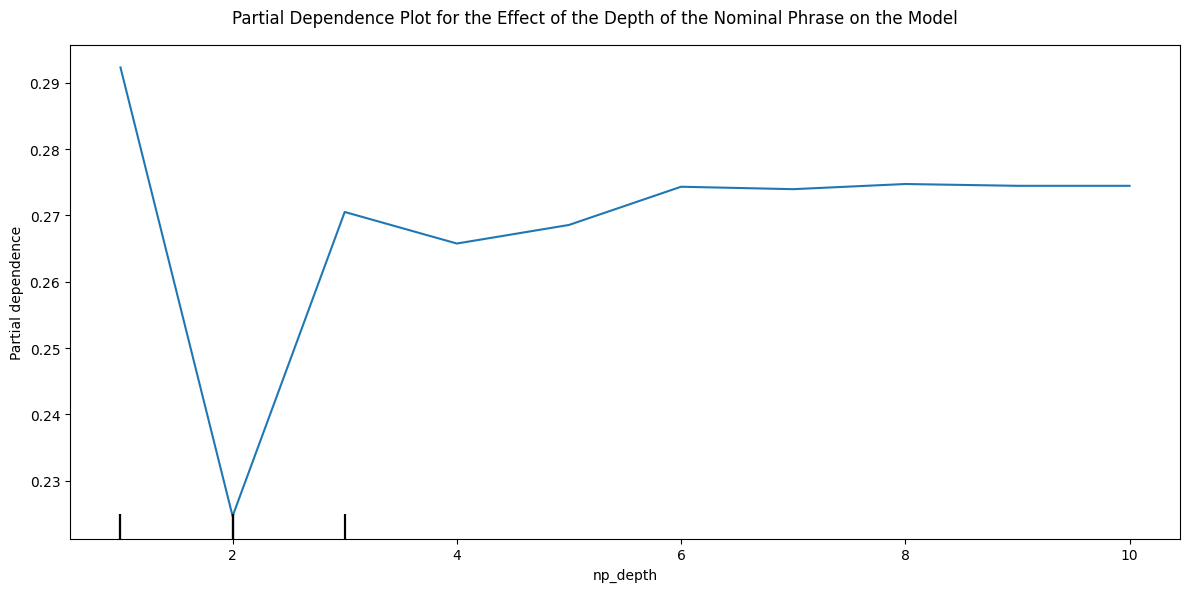

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder for preprocessing

# --- Load Model and Data ---
best_model = joblib.load('random_forest_bestmodel.pkl')
le_combined = joblib.load('label_encoder_combined.pkl')
df = pd.read_csv("rf_inputs.csv")


# --- Data Preprocessing for Features ---
# This block prepares the features by applying the same encoding steps
# that were performed on the data before model training. Categorical features
# are converted into numerical representations, which is necessary for the model
# and for the PDP calculation (Section 6.4).
# The list of categorical columns includes features covering morphosyntax,
# dependency structure, etc., as listed in Tables 13, 14, and 17.
# Handling of potential missing values is also included (Section 6.1).
categorical_cols = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                    'np_deprel_pattern', 'head_number', 'source_file', 'nominal_head_upos',
                    'dependent_form', 'nominal_head_form']

# Initialize LabelEncoders for the specified categorical columns found in the dataframe.
label_encoders = {col: LabelEncoder() for col in categorical_cols if col in df.columns}

for col in label_encoders:
    # Ensure columns are treated as strings and fill any missing values with 'unknown'.
    # This is a standard step in preprocessing categorical data (Section 6.1).
    df[col] = df[col].astype(str).fillna("unknown")
    # Fit the encoder to the unique values in the column and transform the column
    # into a sequence of numerical labels corresponding to the original categories.
    df[col] = label_encoders[col].fit_transform(df[col])

# --- Select Features for Model Input (X) ---
# Create the feature matrix 'X' by selecting the columns that the
# loaded model was trained on. Using 'best_model.feature_names_in_' ensures
# that the features and their order precisely match the model's expectations
# based on its training data. These features are defined in Section 6.3
# and Tables 12-17 (pp. 59-61).
X = df[[col for col in best_model.feature_names_in_ if col in df.columns]]

# --- Display Model Information and Feature Types (Original Prints) ---
# These print statements are included as part of the original script's output.
# "Model classes" lists the numerical indices that represent the different
# categories of the combined target variable the model predicts.
# "Feature dtypes" shows the data type for each column in the feature matrix X,
# verifying that all features are numerical after preprocessing.
print("Model classes:", best_model.classes_)
print("Feature dtypes:\n", X.dtypes)

# --- Generate Partial Dependence Plot (PDP) ---
# This section generates a Partial Dependence Plot (PDP) for the feature
# 'np_depth'. A PDP visualizes the average effect of a single feature's
# value on the model's predicted outcome, marginalizing over the values
# of all other features in the dataset.
# 'np_depth' is a Complexity Indicator feature (Table 14, p. 60) representing
# the syntactic hierarchical levels within the nominal phrase tree.
# The PDP for 'np_depth' is specifically analyzed for its non-linear
# relationship with the model's predictions in Section 6.10.3 (p. 75)
# and is visualized in Figure 30 (p. 76) of the thesis.

# Create the plot figure and axes object using matplotlib.
fig, ax = plt.subplots(figsize=(12, 6))

# Generate the Partial Dependence Plot for the 'np_depth' feature.
# The 'features' parameter specifies that the plot is for 'np_depth'.
# The 'target=0' parameter specifies that the PDP calculates the effect
# on the model's prediction probability for the class with numerical index 0
# in the combined target variable (refer to le_combined.classes_ for the class name).
# 'response_method='predict_proba'' is used to show the dependence on the
# predicted probability of the target class.
PartialDependenceDisplay.from_estimator(
    estimator=best_model, # The trained machine learning model
    X=X,                   # The feature dataset
    features=['np_depth'], # The feature for which to calculate dependence
    target=0,              # Calculate dependence for the target class with index 0
    ax=ax,                 # The matplotlib axes object to draw the plot on
    response_method='predict_proba' # Use predicted probabilities for the y-axis
)

# --- Customize and Display Plot ---
# Set the main title for the plot, clearly indicating the feature being analyzed.
plt.suptitle(f"Partial Dependence Plot for the Effect of the Depth of the Nominal Phrase on the Model")
# Add a subtitle that references the corresponding figure and discussion in the thesis text.
plt.title("As shown in Figure 30 (Section 6.10.3)", fontsize=10)
# Set the x-axis label to clearly identify the feature whose effect is plotted.
plt.xlabel("np_depth")
# Set the y-axis label to indicate what the PDP value represents.
# Get the name of the target class corresponding to index 0 for clarity in the label.
target_class_name = le_combined.classes_[0]
plt.ylabel(f"Partial Dependence (Predicted Probability of '{target_class_name}')")

# Adjust the plot layout to ensure all elements, including titles and labels, are visible.
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the generated plot window.
plt.show()


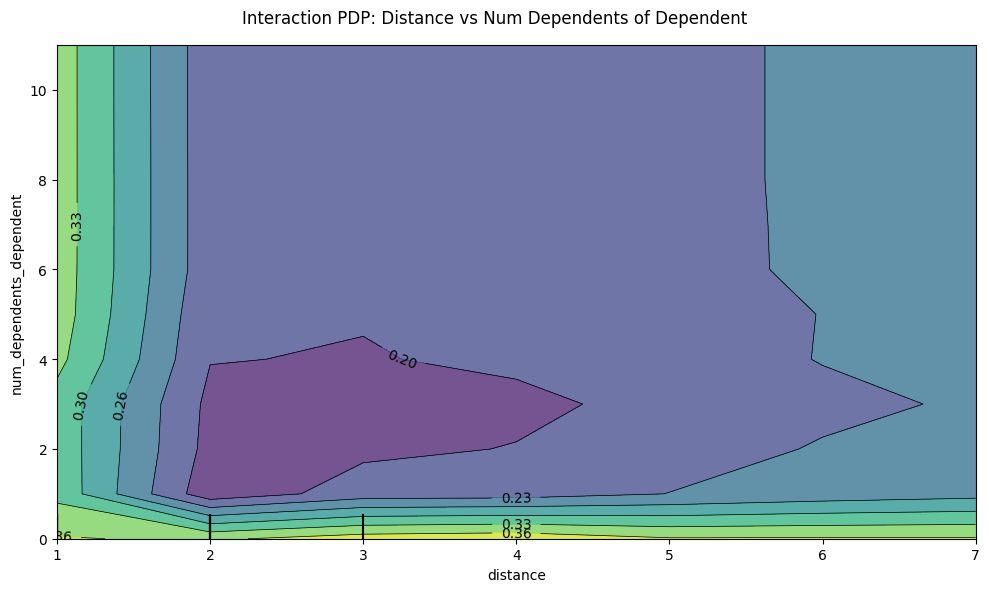

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# --- Load Model and Data ---
# --- Load Model and Data ---
best_model = joblib.load('random_forest_bestmodel.pkl')
le_combined = joblib.load('label_encoder_combined.pkl')
df = pd.read_csv("rf_inputs.csv")

# --- Data Preprocessing for Features ---
# This block prepares the feature data by replicating the preprocessing steps
# applied before training the model. Categorical features are converted into
# numerical format using LabelEncoder. This is necessary for compatibility
# with the machine learning model and the PDP calculation (Section 6.4).
# The list includes features like UPOS tags, dependency relations, etc.,
# as described in Tables 13, 14, and 17 (pp. 59-61).
# Missing values are handled as part of this process (Section 6.1).
categorical_cols = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                    'np_deprel_pattern', 'head_number', 'source_file',
                    'nominal_head_upos', 'dependent_form', 'nominal_head_form']

# Initialize LabelEncoders for the specified categorical columns found in the dataframe.
label_encoders = {col: LabelEncoder() for col in categorical_cols if col in df.columns}
for col in label_encoders:
    # Convert to string and fill potential missing values, consistent with preprocessing.
    df[col] = df[col].astype(str).fillna("unknown")
    # Fit the encoder and transform the column to numerical labels.
    df[col] = label_encoders[col].fit_transform(df[col])

# --- Select Features for Model Input (X) ---
# Create the feature matrix 'X' containing only the columns that the loaded
# model was trained on. Using 'best_model.feature_names_in_' ensures the
# correct set of features and their order are used for the PDP calculation,
# matching the model's expectations based on its training data. Features are
# defined in Section 6.3 and Tables 12-17 (pp. 59-61).
X = df[[col for col in best_model.feature_names_in_ if col in df.columns]]

# --- Display Model Information and Feature Types (Original Prints) ---
# These print statements are part of the original script's output.
# "Model classes" shows the numerical indices representing the combined
# target classes the model is trained to predict (from le_combined).
# "Feature dtypes" displays the data type for each column in the
# feature matrix X, confirming that all are in a numerical format.
print("Model classes:", best_model.classes_)
print("Feature dtypes:\n", X.dtypes)

# --- Generate 2D Partial Dependence Plot (Interaction) ---
# This section generates a 2D Partial Dependence Plot (PDP) to visualize
# the interaction effect between two features: 'distance' and 'num_dependents_dependent'.
# This type of plot shows how the combined values of these two features influence
# the model's prediction, averaged over other features.
# The analysis of this interaction plot is detailed in Section 6.10.3 (p. 76)
# and the visualization is presented in Figure 31 (p. 76) of the thesis.

# Create the plot figure and axes.
fig, ax = plt.subplots(figsize=(10, 6))

# Generate the 2D PDP for the specified feature pair.
# The 'features' parameter takes a list of tuples for interaction plots.
# 'target=0' specifies that the plot visualizes the influence on the model's
# predicted probability for the class with numerical index 0 (refer to
# le_combined.classes_ to identify this class).
# 'kind='average'' is the standard setting for displaying the averaged dependence.
# 'response_method='predict_proba'' is used to plot the dependence on class probability.
PartialDependenceDisplay.from_estimator(
    estimator=best_model, # The trained Random Forest model
    X=X,                   # The feature dataset
    features=[('distance', 'num_dependents_dependent')], # The pair of features for the interaction plot
    target=0,              # Calculate dependence for the target class with index 0
    kind='average',        # Display the average dependence
    ax=ax,                 # The matplotlib axes object to draw on
    response_method='predict_proba' # Use predicted probabilities for the y-axis (color map)
)

# --- Customize and Display Plot ---
# Set the main title for the plot, indicating the interaction being visualized.
plt.suptitle("Interaction PDP: Distance vs Num Dependents of Dependent")
# Add a subtitle referencing the corresponding figure and section in the thesis text.
plt.title("As shown in Figure 31 (Section 6.10.3)", fontsize=10)

# Adjust the plot layout to prevent titles and labels from overlapping.
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle

# Display the generated plot window.
plt.show()


In [ ]:
import shap # Library for SHAP (SHapley Additive exPlanations)
import pandas as pd # For data handling
import matplotlib.pyplot as plt # For plotting
from sklearn.preprocessing import LabelEncoder # To encode categorical features and target
import joblib # To load the trained model

# --- Load Model and Data ---
# This section loads the trained Random Forest model and the dataset.
# The model ('random_forest_bestmodel.pkl') is the classifier discussed
# in Chapter 6.
# The dataset ('nonclausal-np_features.csv') contains the linguistic features
# extracted from the corpus (Section 6.3, 6.4).
model = joblib.load("random_forest_bestmodel.pkl")

# Load the dataset for SHAP analysis.
df = pd.read_csv("rf_inputs.csv")

# --- Data Preprocessing for Features ---
# This block replicates the feature encoding steps applied during model training
# to ensure the data used for SHAP calculation is in the same format the model expects.
# Categorical features are converted to numerical labels using LabelEncoder (Section 6.4).
# Handling missing values is also included (Section 6.1).
categorical_cols = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                    'np_deprel_pattern', 'head_number', 'source_file', 'nominal_head_upos']

label_encoders = {} # Dictionary to store fitted encoders

print("Encoding categorical features...")
for col in categorical_cols:
    # Convert to string and fill potential missing values.
    df[col] = df[col].astype(str).fillna("unknown")
    # Initialize, fit, and transform the column. Store the fitted encoder.
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le # Store the fitted encoder

print("Categorical feature encoding complete.")

# --- Encode Target Labels ---
# Replicate the target label encoding steps performed during model training.
# This includes encoding the original 'ezafe_label', combining it with 'position',
# and then encoding the combined label. This is crucial for understanding
# which SHAP output corresponds to which class (Section 6.4).
print("Encoding target labels...")
le_ezafe = LabelEncoder()
df['ezafe_label'] = le_ezafe.fit_transform(df['ezafe_label'])
print(f"Encoded 'ezafe_label'. Classes: {le_ezafe.classes_}") # Informative print

df['combined_label'] = df['ezafe_label'].astype(str) + "_" + df['position'].astype(str)
le_combined = LabelEncoder()
df['combined_label'] = le_combined.fit_transform(df['combined_label'])
print(f"Encoded 'combined_label'. Classes: {le_combined.classes_}") # Informative print
print("Target label encoding complete.")


# --- Prepare Feature Matrix for SHAP ---
# Select the features (X) that were used to train the model.
# Exclude ID columns, form columns, and the original/combined target labels
# as these are not features used for prediction.
# Features used are described in Section 6.3 and Tables 12-17, with some exclusions
# based on VIF analysis (Section 6.8) or being target variables.
X = df.drop(columns=[
    'nominal_head_id', 'nominal_head_form', # ID and form are identifiers (Table 12), excluded from features.
    'dependent_id', 'dependent_form',       # ID and form are identifiers (Table 12), excluded from features.
    'ezafe_label',                          # This is the original target variable.
    'position',                             # This feature was combined into the target (Footnote 54, p. 61).
    'combined_label'                        # This is the final target variable.
])
# Ensure all selected features are numerical and handle potential conversion errors or NaNs
X = X.apply(pd.to_numeric, errors='coerce').fillna(-1)
print(f"\nPrepared feature matrix X for SHAP analysis. Shape: {X.shape}")
print(f"Features for SHAP analysis: {list(X.columns)}")


# --- SHAP Explanation ---
# Calculate SHAP values to explain the model's predictions.
# SHAP values quantify the contribution of each feature to the prediction
# for individual instances. They are based on Shapley values from game theory.
# This analysis is part of the feature importance evaluation framework (Section 6.4.1, p. 61)
# and is discussed in the context of feature importance across classes (Section 6.10, p. 67).
print("\nCalculating SHAP values...")
# Initialize a TreeExplainer for the trained tree-based model (Random Forest).
# Pass the model and the feature dataset X.
explainer = shap.TreeExplainer(model, X)
# Calculate the SHAP values for the entire dataset X.
# For multi-output models like multi-class classifiers, shap_values is a list
# of arrays, one array for each output class.
shap_values = explainer.shap_values(X)
print("SHAP value calculation complete.")
print(f"SHAP values shape: {len(shap_values)} classes x {shap_values[0].shape[0]} instances x {shap_values[0].shape[1]} features")


# --- Map Encoded Class Labels to Human-Readable Labels ---
# The model outputs predictions for numerical class indices (model.classes_).
# This section maps these numerical indices back to the human-readable
# combined labels (e.g., "No Ezafe & Head Initial") using the fitted
# combined label encoder (le_combined). This is necessary for clear
# visualization titles and labels in the SHAP plots.
decoded_class_labels = le_combined.inverse_transform(model.classes_)

# Define a mapping from the string representations of combined labels
# (e.g., "0_1") to their descriptive names, based on the thesis (Section 6.9, Table 20 classes).
label_mapping = {
    "0_1": "No Ezafe & Head Initial", 
    "0_2": "No Ezafe & Head Final",   
    "1_1": "With Ezafe & Head Initial", 
    "1_2": "With Ezafe & Head Final"  
}

# Create a list of readable class names corresponding to the model's output order.
readable_labels = [label_mapping.get(label, label) for label in decoded_class_labels]
print("\nMapping model class indices to readable labels:")
for idx, name in zip(model.classes_, readable_labels):
    print(f"  Class Index {idx}: {name}")


# --- Plot SHAP Results for Each Class ---
# Iterate through each output class of the model to generate SHAP plots.
# SHAP analysis provides insights into feature importance *for each specific class*,
# as discussed in Section 6.10 (p. 67) and specifically the Mean SHAP values
# across classes (Table 18, Figure 21).
print("\nGenerating SHAP plots for each class...")
for i, class_name in enumerate(readable_labels):
    # 📌 Original print kept as requested
    print(f"\n📌 SHAP Summary for class: {class_name}")

    # --- Generate SHAP Bar Plot ---
    # The bar plot visualizes the average absolute SHAP value for each feature,
    # representing the overall magnitude of each feature's impact on the prediction
    # of the current class. Features are ranked by importance.
    # This aligns with the concept of feature importance discussed in Section 6.4.1
    # and implicitly contributes to the understanding of feature group importance
    # across classes (Table 18, p. 64).
    print(f"  Generating SHAP bar plot for '{class_name}'...")
    # shap.summary_plot for plot_type="bar" takes the list of shap_values (one per class)
    # and the feature data X. The plot will be for shap_values[i].
    shap.summary_plot(shap_values[i], X, plot_type="bar", show=False) # Use show=False to add titles before showing
    plt.title(f"SHAP Feature Importance (Mean Absolute SHAP Value) for Class: {class_name}", fontsize=14)
    plt.tight_layout()
    plt.show() # Show the bar plot

    # --- Generate SHAP Beeswarm Plot ---
    # The beeswarm plot shows the distribution of SHAP values for each feature
    # across the instances in the dataset. It reveals not just the importance
    # but also the direction (positive/negative contribution) and spread of the
    # feature's impact. Red points indicate high feature values, blue points low.
    # This visualization provides granular insight into how features influence
    # predictions for individual data points within the class.
    # This complements the mean SHAP analysis (Figure 21, p. 65) by showing
    # the variability and directional impact.
    print(f"  Generating SHAP beeswarm plot for '{class_name}'...")
    # shap.summary_plot with default plot_type ('beeswarm')
    # show=False is used to add a custom title before showing.
    shap.summary_plot(shap_values[i], X, show=False)
    plt.title(f"SHAP Value Distribution for Class: {class_name}", fontsize=14)
    plt.tight_layout()
    plt.show() # Show the beeswarm plot

print("\nSHAP analysis plots generated for all classes.")

 10%|==                  | 3255/33508 [08:21<77:36]       

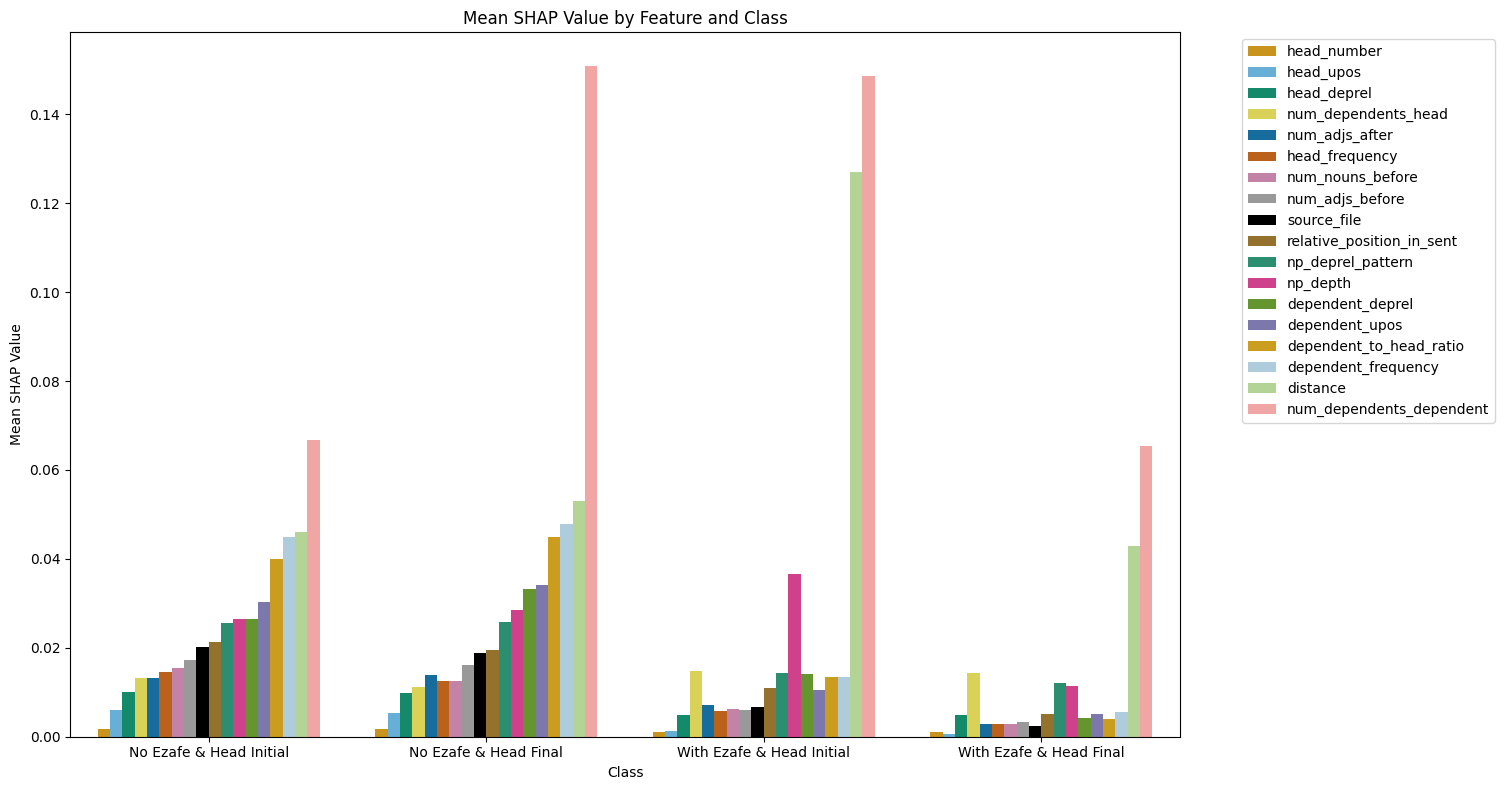

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Define a more distinct colorblind-friendly palette
okabe_ito_palette = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#CC79A7",  # reddish purple
    "#999999",  # grey
    "#000000",  # black
    "#A6761D",  # brown
    "#1B9E77",  # teal
    "#E7298A",  # pink
    "#66A61E",  # green
    "#7570B3",  # purple
    "#E6AB02",  # mustard
    "#A6CEE3",  # pale blue
    "#B2DF8A",  # pale green
    "#FB9A99",  # pale red
]
# Convert the list into a seaborn palette
custom_palette = sns.color_palette(okabe_ito_palette)



# Updated data with new Mean SHAP values for each class, including the missing '0_2' class
mean_shap_data = {
    "0_1": {
        "Feature": ['head_number', 'head_upos', 'head_deprel', 'num_dependents_head',
                    'num_adjs_after', 'head_frequency', 'num_nouns_before', 'num_adjs_before', 'source_file',
                    'relative_position_in_sent', 'np_deprel_pattern', 'np_depth', 'dependent_deprel',
                    'dependent_upos', 'dependent_to_head_ratio', 'dependent_frequency', 'distance',
                    'num_dependents_dependent'],
        "Mean SHAP Value": [0.001626, 0.006070, 0.010030, 0.013271, 0.013304, 0.014562, 0.015481,
                            0.017312, 0.020243, 0.021254, 0.025572, 0.026510, 0.026537, 0.030345, 0.040001,
                            0.044924, 0.045939, 0.066630]
    },
    "0_2": {
        "Feature": ['head_number', 'head_upos', 'head_deprel', 'num_dependents_head',
                    'head_frequency', 'num_nouns_before', 'num_adjs_after', 'num_adjs_before', 'source_file',
                    'relative_position_in_sent', 'np_deprel_pattern', 'np_depth', 'dependent_deprel',
                    'dependent_upos', 'dependent_to_head_ratio', 'dependent_frequency', 'distance',
                    'num_dependents_dependent'],
        "Mean SHAP Value": [0.001846, 0.005309, 0.009942, 0.011245, 0.012481, 0.012558, 0.013910,
                            0.016093, 0.018907, 0.019479, 0.025873, 0.028561, 0.033122, 0.034058, 0.044857,
                            0.047899, 0.053125, 0.150881]
    },
    "1_1": {
        "Feature": ['head_number', 'head_upos', 'head_deprel', 'head_frequency',
                    'num_adjs_before', 'num_nouns_before', 'source_file', 'num_adjs_after', 'dependent_upos',
                    'relative_position_in_sent', 'dependent_to_head_ratio', 'dependent_frequency',
                    'dependent_deprel', 'np_deprel_pattern', 'num_dependents_head', 'np_depth',
                    'distance', 'num_dependents_dependent'],
        "Mean SHAP Value": [0.001015, 0.001369, 0.004823, 0.005761, 0.006021, 0.006248, 0.006644,
                            0.007130, 0.010494, 0.010892, 0.013401, 0.013447, 0.014107, 0.014331,
                            0.014735, 0.036607, 0.127032, 0.148648]
    },
    "1_2": {
        "Feature": ['head_upos', 'head_number', 'source_file', 'num_adjs_after',
                    'num_nouns_before', 'head_frequency', 'num_adjs_before', 'dependent_to_head_ratio',
                    'dependent_deprel', 'head_deprel', 'relative_position_in_sent', 'dependent_upos',
                    'dependent_frequency', 'np_depth', 'np_deprel_pattern', 'num_dependents_head',
                    'distance', 'num_dependents_dependent'],
        "Mean SHAP Value": [0.000531, 0.000985, 0.002435, 0.002832, 0.002837, 0.002839, 0.003279,
                            0.003889, 0.004141, 0.004958, 0.005112, 0.005184, 0.005656, 0.011520,
                            0.011995, 0.014243, 0.042915, 0.065348]
    }
}

# Define human-readable label mapping
label_mapping = {
    "0_1": "No Ezafe & Head Initial",
    "0_2": "No Ezafe & Head Final",
    "1_1": "With Ezafe & Head Initial",
    "1_2": "With Ezafe & Head Final"
}

plot_data = []
for class_id, data in mean_shap_data.items():
    temp_df = pd.DataFrame(data)
    temp_df["Class"] = label_mapping[class_id]
    plot_data.append(temp_df)

plot_df = pd.concat(plot_data)

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(data=plot_df, x="Class", y="Mean SHAP Value", hue="Feature", palette=custom_palette)
plt.title("Mean SHAP Value by Feature and Class")
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
import pandas as pd

# --- Define Feature Groups ---
# This dictionary defines the grouping of features based on their linguistic category,
# as established in the thesis (e.g., Section 6.3 for feature extraction,
# with categories like Identifiers, Morphosyntactic Properties, Complexity Indicators,
# Lexical Features, Placement Features, and Text Properties, corresponding to
# Tables 12-17, pp. 59-61).
# These groupings are used to analyze the collective contribution of related features,
# as discussed in the context of feature importance analysis (Section 6.4.1)
# and specifically for mean SHAP values across classes (Section 6.10, p. 64, Table 18).
feature_groups = {
    # Features related to the source text file.
    # Corresponds to Text Properties (Table 17, p. 61).
    "Source Info": ['source_file'],

    # Features describing grammatical properties like Part-of-Speech (UPOS),
    # dependency relations (deprel), and number marking.
    # Corresponds to Morphosyntactic Properties (Table 13, p. 59) and
    # relevant parts of Complexity Indicators (Table 14, p. 60) like np_deprel_pattern.
    "Morphosyntactic": ['head_upos', 'head_deprel', 'dependent_upos', 'dependent_deprel',
                        'head_number', 'np_deprel_pattern'],

    # Features that quantify the structural complexity or "heaviness" of the nominal phrase.
    # Corresponds to Complexity Indicators (Table 14, p. 60).
    "Structural": ['np_depth', 'num_nouns_before', 'num_nouns_after', 'num_adjs_before',
                   'num_adjs_after', 'num_dependents_head', 'num_dependents_dependent', 'distance'],

    # Features based on the frequency of the head and dependent lemmas.
    # Corresponds to Lexical and Frequency-Based Features (Table 15, p. 60).
    "Lexical": ['head_frequency', 'dependent_frequency'],

    # Features related to the position of the head and dependent within the``` sentence or phrase.
    # Corresponds to Placement Features (Table 16, p. 60).
    "Placement": ['relative_position_in_sent']
}

# --- Assume mean_shap_data is Loaded/Available ---
# Note: The names 'Source Info', 'Morphosyntactic', 'Structural', 'Lexical', 'Placement'
# are used here to correspond to the feature groups discussed in the thesis.
# The features included in each group are based on Tables 13-17 (pp. 59-61)
# and the analysis in Section 6.4. in Section 6.10 (p. 67) and visualized in Figure 21 (p. 65),
# which shows mean SHAP values per feature across classes.
# Example structure (conceptual):
# mean_shap_data = {
#     0: {'Feature': ['feat1', 'feat2', ...], 'Mean SHAP Value': [0.1, 0.05, ...]}, # Data for class 0
#1.
feature_groups = {
    "Source Info": ['source_file'],  # Features related to the source text (Table 17)
    "Morphosyntactic": ['head_upos', 'head_deprel', 'dependent_upos', 'dependent_deprel',
                        'head_number', 'np_deprel_pattern'], # POS tags, dependency relations, number (Table 13, 14)
    "Structural": ['np_depth', 'num_nouns_before', 'num_nouns_after', 'num_adjs_before',
                   'num_adjs_after', 'num_dependents_head',     1: {'Feature': ['feat1', 'feat2', ...], 'Mean SHAP Value': [0.08, 0.12, ...]}, # Data for class 1
#     ...
# }

# --- Summarize SHAP Values by Feature Group ---
# This block calculates the total Mean SHAP Value for each feature group within
# each class. It 'num_dependents_dependent', 'distance'], # Complexity indicators (Table 14), distance (Table 14)
    "Lexical": ['head_frequency', 'dependent_frequency'], # Frequency-based features (Table 15)
    "Placement": ['relative_position_in_sent'] # Features related to position (Table 16)
}

# --- Load or Assume Mean SHAP Data ---
group_summary = {} # Dictionary to store the percentage summary per group per class

# Loop through the Mean SHAP data for each class.
for class_id, data in mean_shapdata' is a dictionary where keys are class identifiers
# The mean SHAP values per feature across classes are_data.items():
    # Convert the data for the current class into a pandas DataFrame for easier handling.
    df = pd.DataFrame(data)
    # Calculate the sum of Mean SHAP values for all features in the current class.
    total = df["Mean SHAP Value"].sum()

    # Calculate the sum of Mean SHAP values for features within each defined group.
    group_shap = {} # Dictionary to store summed SHAP values for groups in the current class
    for group, features in feature_groups.items():
        # Filter the DataFrame to include only features belonging to the current group,
        # sum their Mean SHAP Values, and calculate the percentage of analyzed in Section 6.10 and presented
# in Figure 21 (p. 65).
        value = df[df["Feature"].isin(features)]["Mean SHAP Value"].sum()
        group_shap[group] = (value / total) * 100  # Calculate percentage contribution
    # Store the percentage contributions for the current class in the summary dictionary.
    group_summary[class_id] = group_shap

# --- Create and Display Summary DataFrame ---
# Convert the calculated group summaries into a pandas DataFrame for clear Value": v1}, ...], ... }


# --- Calculate Grouped SHAP Importance Percentages ---
# This section calculates the percentage contribution of each feature group
# to the total mean SHAP value for each class. This provides a summary of
# how much each category of features influences the model's predictions
# for different classes. This calculation supports the analysis of feature
# group importance across classes, similar to Table 18 (p. 64).
group_summary = {} presentation.
group_shap_df = pd.DataFrame(group_summary)
# Round the percentage values for readability.
group_shap_df = group_shap_df.round(2)

# Display the DataFrame containing the percentage contribution of feature groups per class.
print(group_shap_df)

# --- Save Summary to CSV ---
# Save the resulting DataFrame to a CSV file.
group_shap_df.to_csv("shap_group_percentages.csv")



                   0_1    0_2    1_1    1_2
Source Info       4.60   3.50   1.50   1.28
Morphosyntactic  22.79  20.39  10.42  14.57
Structural       45.14  53.02  78.25  74.97
Lexical          13.53  11.18   4.34   4.45
Placement         4.83   3.61   2.46   2.68


No Ezafe & Head Initial: AUC = 0.9933
No Ezafe & Head Final: AUC = 0.9937
With Ezafe & Head Initial: AUC = 0.9980
With Ezafe & Head Final: AUC = 1.0000


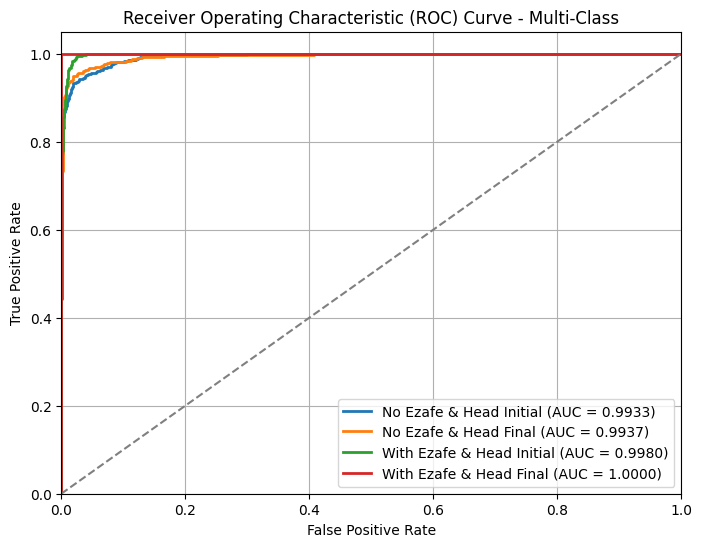

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Imported but not directly used in this script block
# Removed: from sklearn.ensemble import RandomForestClassifier # Model is loaded, not instantiated and trained here
# Removed: from sklearn.model_selection import RandomizedSearchCV # Hyperparameter tuning is not performed here
from conllu import parse_incr # Imported but not directly used in this script block
from imblearn.over_sampling import RandomOverSampler # Used for oversampling to prepare data for splitting
from sklearn.model_selection import train_test_split # Used for splitting the data
from sklearn.preprocessing import LabelEncoder, label_binarize # Used for encoding and binarization
from sklearn.metrics import classification_report as sklearn_classification_report, confusion_matrix, roc_curve, auc # Used for evaluation metrics
import joblib # Used for loading models and encoders

# --- File Paths ---
MODEL_PATH = 'random_forest_bestmodel.pkl' # Assuming this is the file name of the saved model


# --- Main Function ---
# This function orchestrates the steps to load data, preprocess it,
# load a pre-trained model, evaluate its performance using ROC curves
# and AUC scores, and visualize the results.
# This process follows the evaluation methodology described in Section 6.10.
def main():
    # --- Load Dataset ---
    # Load the dataset containing the extracted linguistic features.
    # This CSV file serves as the source data for preparing the model's input.
    # The dataset and its features are detailed in Section 6.3 and 6.4.
    df = pd.read_csv("nonclausal-np_features.csv")
    print("Dataset loaded.")

    # --- Encode Categorical Features ---
    # Transform categorical features (e.g., UPOS tags, dependency relations)
    # into a numerical format. This encoding is a necessary preprocessing step
    # before providing the data to the machine learning model (Section 6.4).
    # The list of categorical columns is based on the features described
    # in Section 6.3 and Tables 13, 14, 17. Missing values are handled as per Section 6.1.
    categorical_cols = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                        'np_deprel_pattern', 'head_number', 'source_file', 'nominal_head_upos']

    label_encoders = {col: LabelEncoder() for col in categorical_cols} # Initialize encoders
    print("Encoding categorical features...")
    for col in categorical_cols:
        # Convert the column to string type and fill any missing values with 'unknown'.
        df[col] = df[col].astype(str).fillna("unknown")
        # Fit the encoder on the column's data and transform the data to numerical labels.
        df[col] = label_encoders[col].fit_transform(df[col])
    print("Categorical features encoded.")

    # --- Encode the Combined Target Variable ---
    # Create a combined target variable by merging the 'ezafe_label'
    # (presence/absence of ezafe) and 'position' (head position).
    # This combined variable represents the four classification categories
    # the model predicts (Section 6.4). It is then encoded into numerical labels.
    df['combined_label'] = df['ezafe_label'].astype(str) + "_" + df['position'].astype(str)
    le_combined = LabelEncoder() # Initialize the encoder for the combined label
    df['combined_label'] = le_combined.fit_transform(df['combined_label']) # Fit and transform the combined labels
    print("Combined target variable encoded.")
    print(f"Encoded target classes: {le_combined.classes_}") # Show the numerical labels corresponding to the classes


    # --- Define Features (X) and Target (y) ---
    # Separate the dataset into the feature matrix (X) and the target variable (y).
    # Columns that are identifiers, original forms, or the original/intermediate
    # target variables are dropped, keeping only the features used as input to the model.
    # Feature selection is based on Section 6.4 and Tables 12-17, considering
    # that 'position' becomes part of the combined target.
    X = df.drop(columns=['nominal_head_id', 'nominal_head_form', 'dependent_id',
                         'dependent_form', 'ezafe_label', 'position', 'combined_label'])
    y = df['combined_label']
    print(f"Features shape (X): {X.shape}, Target shape (y): {y.shape}")

    # --- Handle Class Imbalance ---
    # Apply Random Oversampling to address the significant class imbalance
    # in the original dataset (Section 6.5, Figure 22). This step is performed
    # *before* splitting to ensure the subsequent stratified split is applied
    # to a balanced dataset, leading to test sets representative of the
    # balanced class distribution used during training (Section 6.5).
    ros = RandomOverSampler(sampling_strategy='auto', random_state=42) # 'auto' balances all classes
    X_resampled, y_resampled = ros.fit_resample(X, y) # Apply oversampling
    print("Class imbalance handled using Random Oversampling.")
    print(f"Resampled data shape (X_resampled): {X_resampled.shape}, Resampled target shape (y_resampled): {y_resampled.shape}")


    # --- Split Data ---
    # Split the resampled dataset into training and testing sets.
    # A test size of 20% is used (Section 6.7). Stratified splitting ensures
    # that the now-balanced class distribution is maintained in both the
    # training and testing partitions. The test set (X_test, y_test) is used
    # for evaluating the loaded model.
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size=0.2, random_state=42, stratify=y_resampled)
    print("Data split into training and testing sets.")
    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    # --- Load Trained Model ---
    # Load the pre-trained Random Forest classifier from the specified file.
    # This replaces the training step (best_model.fit) from previous scripts,
    # allowing evaluation of an already finalized model. The loaded model
    # is expected to be the result of training with optimized hyperparameters
    # and potentially on resampled data (Section 6.7, 6.9).
    print(f"\nLoading trained model from {MODEL_PATH}...")
    try:
        best_model = joblib.load(MODEL_PATH)
        print("Model loaded successfully.")
        # Optional: Check model attributes to confirm it's loaded correctly
        # print(f"Model type: {type(best_model)}")
        # print(f"Number of estimators: {best_model.n_estimators}")
    except FileNotFoundError:
        print(f"Error: Model file not found at {MODEL_PATH}.")
        print("Please ensure the trained model file exists in the correct location.")
        return # Exit the function if the model cannot be loaded
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")
        return # Exit the function on other loading errors


    # --- Evaluate Model using ROC and AUC ---
    # Evaluate the loaded model's discriminative performance on the test set
    # using Receiver Operating Characteristic (ROC) curves and the Area Under
    # the Curve (AUC). This analysis is part of the model evaluation process
    # (Section 6.10), with ROC/AUC specifically discussed in Section 6.10.1
    # and visualized in Figure 25 (p. 71).

    # Get the predicted probabilities for each class on the test set.
    # These probabilities are needed to compute ROC curves and AUC scores.
    y_prob = best_model.predict_proba(X_test) # Probabilities for all classes

    # Binarize the true test labels. For multi-class classification, ROC/AUC
    # is typically calculated in a one-vs-rest manner. Binarizing the labels
    # converts the single target column into a binary matrix suitable for this.
    y_test_binarized = label_binarize(y_test, classes=np.arange(len(le_combined.classes_)))

    # Compute False Positive Rate (FP), True Positive Rate (TP), and AUC for each class.
    fpr, tpr, roc_auc = {}, {}, {} # Dictionaries to store results for each class
    print("\nComputing ROC curves and AUC scores for each class...")
    for i in range(len(le_combined.classes_)):
        # Calculate FPR, TPR, and thresholds for the current class vs. all others.
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
        # Calculate the AUC for the ROC curve of the current class.
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Map the numerical class index back to a human-readable label for output.
        class_str = le_combined.classes_[i] # Get the original encoded string label (e.g., "0_1")
        # Define the mapping from encoded string to descriptive name, based on the four classes (Section 6.4, Table 20).
        label_mapping = {
            "0_1": "No Ezafe & Head Initial",
            "0_2": "No Ezafe & Head Final",
            "1_1": "With Ezafe & Head Initial",
            "1_2": "With Ezafe & Head Final"
        }
        human_label = label_mapping.get(class_str, class_str) # Get descriptive name, fall back to string if not found

        # Print the calculated AUC score for the current class.
        print(f"{human_label}: AUC = {roc_auc[i]:.4f}")

    # --- Plot ROC Curve ---
    # This visualization corresponds to Figure 25 in Section 6.10.1 (p. 71)
    # and illustrates the model's ability to distinguish between classes.
    plt.figure(figsize=(8, 6)) # Create the plot figure

    for i in range(len(le_combined.classes_)):
        # Map the numerical class index to the human-readable label for the legend.
        class_str = le_combined.classes_[i]
        # Use the previously defined label_mapping.
        label_mapping = {
            "0_1": "No Ezafe & Head Initial",
            "0_2": "No Ezafe & Head Final",
            "1_1": "With Ezafe & Head Initial",
            "1_2": "With Ezafe & Head Final"
        }
        human_label = label_mapping.get(class_str, class_str)

        # Plot the ROC curve for the current class (FPR vs TPR).
        # The label for the legend includes the class name and its AUC score.
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{human_label} (AUC = {roc_auc[i]:.4f})')

    # Plot the diagonal line representing a random classifier (AUC = 0.5) as a baseline.
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

    # Set the plot's limits, labels, title, and legend for clarity and interpretation.
    plt.xlim([0.0, 1.0]) # Set x-axis limits for False Positive Rate
    plt.ylim([0.0, 1.05]) # Set y-axis limits for True Positive Rate
    plt.xlabel('False Positive Rate') # Label for the x-axis
    plt.ylabel('True Positive Rate') # Label for the y-axis
    plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-Class') # Main title of the plot
    plt.legend(loc='lower right') # Position the legend
    plt.grid(True) # Add a grid to the plot

    # Display the generated plot.
    plt.show()

# --- Script Entry Point ---
if __name__ == "__main__":
    main()

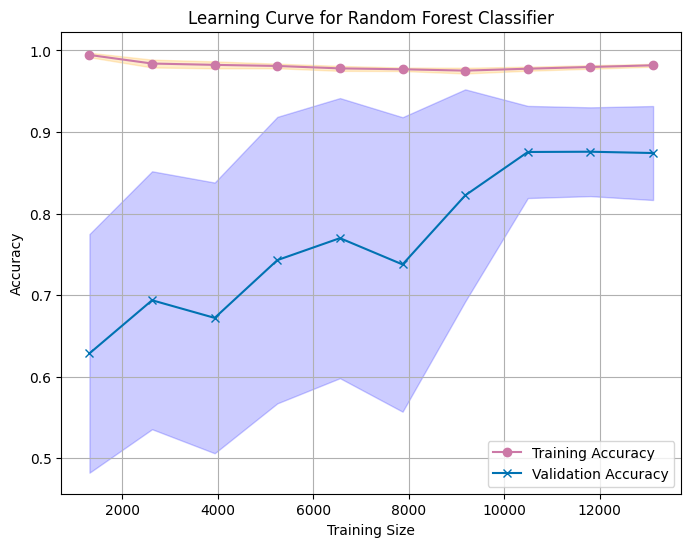

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Imported but not directly used in this script block
from conllu import parse_incr # Imported but not directly used in this script block
from imblearn.over_sampling import RandomOverSampler # Used for oversampling
from sklearn.model_selection import train_test_split, learning_curve # learning_curve used for plotting
from sklearn.ensemble import RandomForestClassifier # Used for the model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report as sklearn_classification_report, confusion_matrix, roc_curve, auc # Metrics imported but not used in this script block
import joblib
from sklearn.preprocessing import label_binarize # Imported but not used in this script block

# --- Main Function ---
# This function executes the main workflow of the script: loading data,
# preprocessing, handling class imbalance, preparing data for the model,
# instantiating a Random Forest model with specified parameters, calculating
# its learning curve, and plotting the results.
# The generation and analysis of the learning curve are part of the model
# evaluation process described in Section 6.10.2 (p. 71).
def main():
    # --- Load Dataset ---
    # Load the dataset containing the engineered linguistic features.
    # This dataset is the input for the machine learning model as described
    # in Section 6.4.
    df = pd.read_csv("rf_inputs.csv")

    # --- Encode Categorical Features ---
    # Transform categorical features into a numerical format required by
    # the machine learning model. This is a standard preprocessing step
    # (Section 6.4), including handling potential missing values (Section 6.1).
    # The list of categorical columns includes various linguistic properties
    # (Tables 13, 14, 17, pp. 59-61).
    categorical_cols = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel', 'np_deprel_pattern', 'head_number', 'source_file', 'nominal_head_upos']
    label_encoders = {col: LabelEncoder() for col in categorical_cols} # Initialize encoders
    for col in categorical_cols:
        # Convert column to string and fill missing values before encoding.
        df[col] = df[col].astype(str).fillna("unknown")
        # Fit the encoder and transform the column to numerical labels.
        df[col] = label_encoders[col].fit_transform(df[col])

    # --- Encode the Combined Target Variable ---
    # Create a combined target variable by concatenating the 'ezafe_label'
    # (presence/absence of ezafe) and 'position' (head position).
    # This combined variable defines the four classification categories
    # (Section 6.4) and is then encoded into numerical labels for the model.
    df['combined_label'] = df['ezafe_label'].astype(str) + "_" + df['position'].astype(str)
    le_combined = LabelEncoder() # Initialize encoder for combined label
    df['combined_label'] = le_combined.fit_transform(df['combined_label']) # Fit and transform

    # --- Define Features (X) and Target (y) ---
    # Separate the DataFrame into the feature matrix (X) and the target variable (y).
    # Columns that are identifiers, original forms, or parts of the target variable
    # (original/intermediate) are excluded from the features.
    # Features are based on Section 6.3 and Tables 12-17, excluding those used for the target.
    X = df.drop(columns=['nominal_head_id', 'nominal_head_form', 'dependent_id', 'dependent_form', 'ezafe_label', 'position', 'combined_label'])
    y = df['combined_label']

    # --- Handle Class Imbalance ---
    # Apply Random Oversampling to address the significant class imbalance
    # identified in the dataset (Section 6.5, Figure 22). Oversampling duplicates
    # instances from minority classes to equalize the class distribution,
    # which helps the model learn patterns from all categories effectively.
    ros = RandomOverSampler(sampling_strategy='auto', random_state=42) # 'auto' strategy balances all classes
    X_resampled, y_resampled = ros.fit_resample(X, y) # Apply oversampling to features and target

    # --- Split Data ---
    # Split the resampled data into training and testing sets.
    # This step prepares the data for cross-validation within the learning curve calculation.
    # Stratified splitting ensures the balanced class distribution is maintained.
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

    # --- Model Initialization ---
    # Initialize the Random Forest Classifier with specific hyperparameters.
    # These parameters ('n_estimators', 'min_samples_split', 'max_depth', 'class_weight')
    # are set based on the results of hyperparameter tuning (Section 6.6)
    # and correspond to the optimal configuration for the best model (Section 6.9, Table 19).
    best_params = {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 15, 'class_weight': 'balanced'} # Based on Section 6.6, 6.9
    best_model = RandomForestClassifier(random_state=42, **best_params)

    # --- Model Training (on a full split, though learning_curve retrains) ---
    # The learning_curve function will internally train the model multiple times
    # on subsets of the data. This fit here might not be strictly necessary for
    # the learning_curve function itself, but aligns with a typical workflow.
    # The model training process is described in Section 6.7.
    best_model.fit(X_train, y_train)


    # --- Learning Curve Calculation ---

    # --- Initialize Model (Using Best Parameters) ---
    # Initialize the Random Forest classifier with the best hyperparameters
    # identified during tuning (Section 6.6, 6.9).
    best_params = {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 15, 'class_weight': 'balanced'} # Based on Section 6.6, 6.9
    best_model = RandomForestClassifier(random_state=42, **best_params)
    print("Model initialized with best parameters.")

    # --- Learning Curve Calculation ---
    # Calculate the learning curve data. This function trains the model
    # multiple times on subsets of the data of increasing size and evaluates
    # performance (accuracy) on both the training subset and a cross-validation set.
    print("Calculating learning curve...")
    train_sizes, train_scores, test_scores = learning_curve(
        best_model, X_resampled, y_resampled, cv=5, scoring='accuracy', n_jobs=-1,
        train of the dataset
    # and evaluates its performance (using accuracy in this case) on both the
    # training and cross-validation sets for each training size.
    # This calculation provides the data points needed to plot the learning curve,
    # which shows how model performance changes with increasing training data size.
    # The process is detailed in Section 6.10.2 (p. 71).
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=best_model, # The model to evaluate
        X=X_resampled,        # The dataset to draw training subsets from (using resampled data)
        y=y_resampled,        # The corresponding target variable
        cv=5,                 # Number of cross-validation folds (5-fold CV)
        scoring='accuracy',   # The evaluation metric
        n_jobs=-1,            # Use all available CPU cores for faster computation
        train_sizes=np.linspace(0.1, 1.0, 10) # Sizes of the training subsets (10 points from 10% to 100%)
    )

    # --- Calculate Mean and Standard Deviation of Scores ---
    # Compute the mean and standard deviation of the training and testing (cross-validation)
    # scores obtained from the learning_curve calculation for each training size.
    # The mean scores are used to draw the central learning curves, and the standard
    # deviation is used to plot the shaded areas indicating variability across CV folds.
    # These calculations are standard steps for visualizing learning curves.
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # --- Plot the Learning Curve ---
    # Generate a plot showing the learning curve, which visualizes the relationship
    # between model performance (accuracy) and the amount of training data.
    # This plot corresponds to Figure 26 in Section 6.10.2 (p. 72) and helps
    # assess model behavior regarding overfitting and generalization.
    colors = ['#CC79A7', '#0072B2'] # Define colors for the curves, matching Figure 26 visually

    # Create the plot figure.
    plt.figure(figsize=(8, 6))

    # Plot the mean training accuracy curve.
    plt.plot(train_sizes, train_mean, label='Training Accuracy', color=colors[0], marker='o')
    # Plot the mean cross-validation accuracy curve.
_sizes=np.linspace(0.1, 1.0, 10) # Evaluate at 10 different training set sizes from 10% to 100%
    )
    print("Learning curve calculation complete.")

    # --- Process Learning Curve Scores ---
    # Calculate the mean and standard deviation of the training and cross-validation
    # scores across the different folds for each training set size.
    # These means and standard deviations are used to plot the learning curve
    # and the confidence intervals around the mean scores.
    train_mean = np.mean(train_scores, axis=1) # Mean training scores for each size
    test_mean = np.mean(test_scores, axis=1)   # Mean test (validation) scores for each size
    train_std = np.std(train_scores, axis=1)   # Standard deviation of training scores
    test_std = np.std(test_scores, axis=1)     # Standard deviation of test scores

    # --- Plot the Learning Curve ---
    # This plot visualizes the model's training and validation performance
    # as the training set size increases. It helps diagnose overfitting/underfitting
    # and assess the model's learning capacity with more data.
    # This visualization corresponds to Figure 26 in Section 6.10.2 (p. 72).
    colors = ['#CC79A7', '#0072B2']

    plt.figure(figsize=(8, 6)) # Create the plot figure

    # Plot the mean training accuracy curve.
    plt.plot(train_sizes, train_mean, label='Training Accuracy', color=colors[0], marker='o')
    # Plot the mean validation accuracy curve.
    plt.plot(train_sizes, test_mean, label='Validation Accuracy',  color=colors[1], marker='x')

    # Fill the area between the mean score plus/minus one standard deviation.
    # This represents the variability in scores across cross-validation folds.
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='orange', alpha=0.2')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', alpha=0.2)

    # --- Customize Plot ---
    # Set the title, axis labels, legend, and grid for the plot.
    plt.title('Learning Curve for Random Forest Classifier') # Main plot title (Section 6.10.2, Figure 26)
    plt.xlabel('Training Size') # Label for the x-axis
    plt.ylabel('Accuracy') # Label for the y-axis (scoring='accuracy')
    plt.legend(loc='best') # Position the legend
    plt.grid(True) # Add a grid for readability

    # --- Display Plot ---
    plt.show()

# --- Script Entry Point ---
if __name__ == "__main__":
    main()


 17 Full Feature Importance Report:
                      Feature  Importance
14   num_dependents_dependent    0.168608
8                    distance    0.148439
17          np_deprel_pattern    0.080911
12                   np_depth    0.069579
16  relative_position_in_sent    0.064433
4         dependent_frequency    0.061885
13        num_dependents_head    0.051609
5      modifier_to_head_ratio    0.049337
3              head_frequency    0.044123
18                source_file    0.039332
6              dependent_upos    0.038228
9            num_nouns_before    0.038011
1         nominal_head_deprel    0.036844
7            dependent_deprel    0.036520
10            num_adjs_before    0.028119
11             num_adjs_after    0.026472
0           nominal_head_upos    0.012371


C:\Users\rahaa\AppData\Local\Temp\ipykernel_32664\2130287795.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(top_n), x='Importance', y='Feature', palette="viridis")


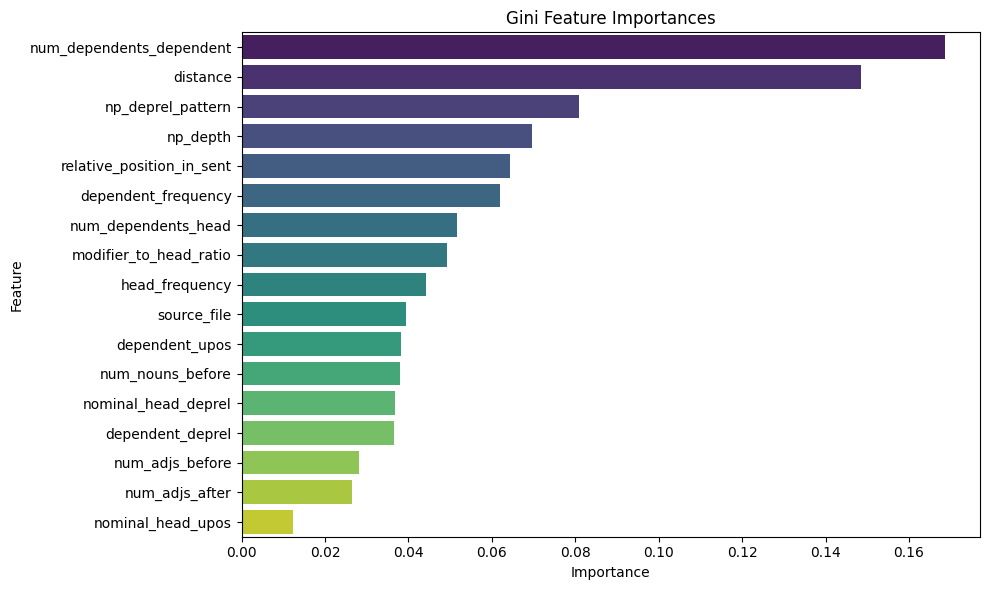

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder

# --- Load Model and Data ---
# Load the trained Random Forest model and the dataset.
# The model ('random_forest_model-1.pkl') is the classifier from Chapter 6.
# The dataset ('nonclausal-np_features.csv') contains the features (Section 6.3, 6.4).
best_model = joblib.load('random_forest_model-1.pkl')
df = pd.read_csv("nonclausal-np_features.csv")

# --- Encode Categorical Features ---
# Encode categorical features to numerical format, as done for model training.
# This step ensures the feature names in X match the model's expected features
# after preprocessing (Section 6.4). Includes handling missing values (Section 6.1).
categorical_cols = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                    'np_deprel_pattern', 'head_number', 'source_file', 'nominal_head_upos']

label_encoders = {col: LabelEncoder() for col in categorical_cols if col in df.columns}

for col in label_encoders:
    df[col] = df[col].astype(str).fillna("unknown")
    df[col] = label_encoders[col].fit_transform(df[col])

# --- Prepare Feature Matrix (X) ---
# Recreate the feature matrix X to include all columns that the model was trained on.
# Using best_model.feature_names_in_ ensures feature consistency.
# Features are defined in Section 6.3, Tables 12-17.
X = df.reindex(columns=best_model.feature_names_in_, fill_value=0)

# --- Extract Gini Feature Importances ---
# Extract feature importances from the trained Random Forest model.
# These are Gini importances, which measure how much each feature reduces impurity
# across all trees in the forest. This is one method of feature importance analysis
# discussed in Section 6.4.1 (p. 61) and shown in Figure 19 (p. 62).
importances = best_model.feature_importances_

# Verify that the number of calculated importances matches the number of features in X.
if len(importances) != X.shape[1]:
    raise ValueError(f"Mismatch between feature importances ({len(importances)}) and features ({X.shape[1]}).")

# Create a DataFrame to store features and their importances, then sort by importance.
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# --- Print Top Features ---
# Display the top N features and their Gini importance scores.
# This provides a summary of the most influential features according to the Gini criterion.
# The ranking and interpretation of these importances are discussed in Section 6.4.1.
top_n = 17
print(f"\n {top_n} Full Feature Importance Report (Gini):") # Clarified type of importance
print(feature_importance_df.head(top_n))

# --- Plot Feature Importances ---
# Generate a bar``` plot to visualize the top N feature importances.
# This plot graphically represents the importance of each feature, making it easier
# to identify the most influential ones visually. This plot corresponds to
# Figure 19 in Section 6.4.python
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(top_n), x='Importance', y='Feature',

# --- Load Model and Data ---
# Loads the trained Random Forest model and the dataset used for training.
# This is the setup for extracting Gini feature importances from palette="viridis")
plt.title(f'Gini Feature Importances') # Added top_n to title for clarity
plt.tight_layout()
plt.show()

# No final print message, maintaining consistency with the original script.

Calculating permutation importances...


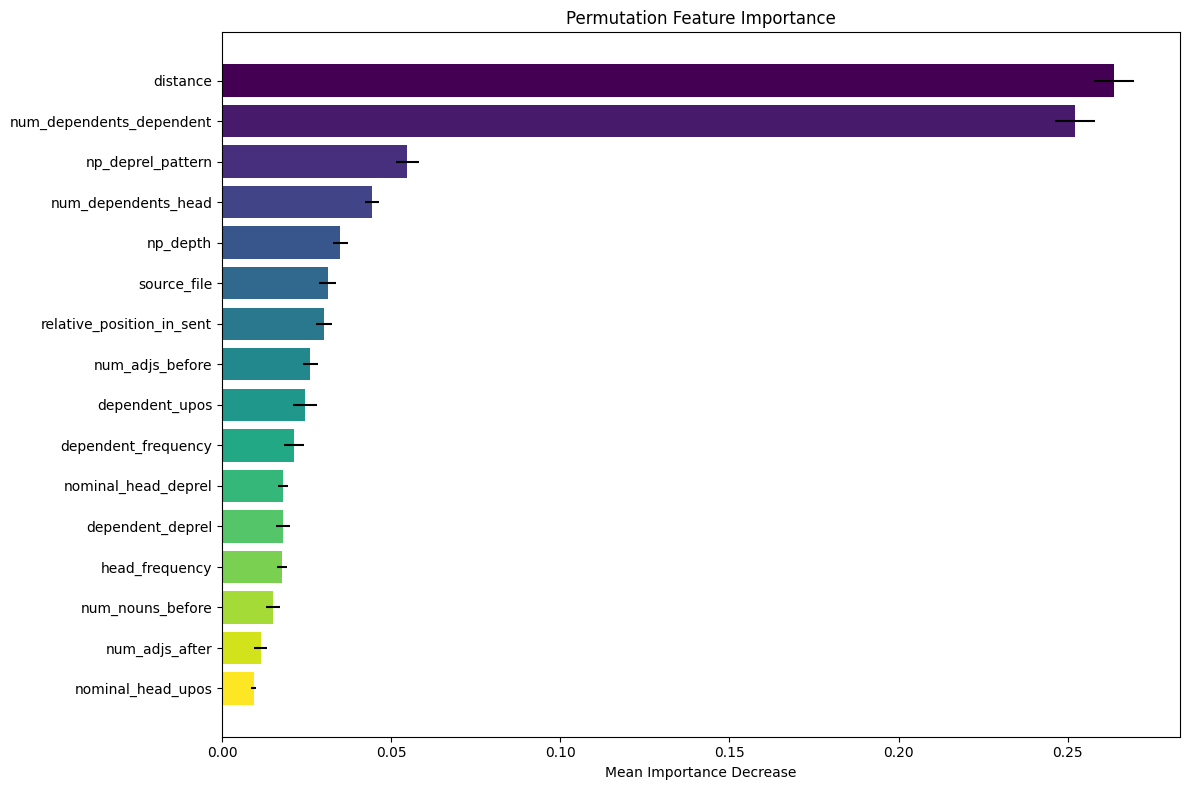

                      Feature  Importance Mean  Importance Std
7                    distance         0.263710        0.006011
13   num_dependents_dependent         0.252220        0.005884
16          np_deprel_pattern         0.054780        0.003365
12        num_dependents_head         0.044377        0.002087
11                   np_depth         0.034979        0.002325
17                source_file         0.031251        0.002552
15  relative_position_in_sent         0.030123        0.002337
9             num_adjs_before         0.026039        0.002224
5              dependent_upos         0.024525        0.003645
4         dependent_frequency         0.021193        0.002999
1         nominal_head_deprel         0.018023        0.001529
6            dependent_deprel         0.017972        0.001979
3              head_frequency         0.017830        0.001495
8            num_nouns_before         0.014945        0.002038
10             num_adjs_after         0.011440        0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Imported
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import RandomOverSampler
import joblib

# --- Data Preprocessing Function ---
# Preprocesses data for model evaluation: loads, encodes, selects features,
# ensures numeric types, reorders, oversamples, and splits.
# Mirrors training preprocessing (Section 6.1, 6.3, 6.4).
def preprocess_data(file_path, feature_order):
    df = pd.read_csv(file_path)

    # Encode categorical features (Section 6.4), handles missing values (Section 6.1).
    categorical_cols = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                        'np_deprel_pattern', 'head_number', 'source_file', 'nominal_head_upos']
    label_encoders = {}

    from sklearn.preprocessing import LabelEncoder

    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).fillna("unknown")
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
        else:
             print(f"Warning: Categorical column '{col}' not found in dataframe.")

    # Encode target: combine ezafe/position, then encode (Section 6.4).
    le_ezafe = LabelEncoder()
    df['ezafe_label'] = le_ezafe.fit_transform(df['ezafe_label'])

    df['combined_label'] = df['ezafe_label'].astype(str) + "_" + df['position'].astype(str)

    le_combined = LabelEncoder()
    df['combined_label'] = le_combined.fit_transform(df['combined_label'])

    # Drop non-feature columns (IDs, forms, original/intermediate targets) (Section 6.4).
    drop_cols = ['nominal_head_id', 'nominal_head_form', 'dependent_id', 'dependent_form',
                 'ezafe_label', 'position', 'combined_label']
    X = df.drop(columns=drop_cols, errors='ignore')
    y = df['combined_label']

    # Ensure all features are numeric, filling NaNs with -1.
    print("Ensuring features are numeric...")
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(-1)
    print("Numeric conversion complete.")

    # Reorder features to match the model's training order. Critical for compatibility.
    print("Reordering features to match model's training order...")
    X = X.reindex(columns=feature_order, fill_value=0)
    print("Feature reordering complete.")

    # Apply Random Oversampling to handle class imbalance (Section 6.5, Figure 22).
    # Applied before split for balanced test set.
    print("Applying Random Oversampling...")
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    print("Oversampling complete.")
    print(f"Resampled data shape: {X_resampled.shape}")

    # Split resampled data into train and test sets (Section 6.7).
    # Stratified split maintains balance. Test set used for importance.
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
    )
    print("Data split into training and test sets.")
    print(f"Test set shape for importance calculation: {X_test.shape}")

    return X_train, X_test, y_train, y_test

# --- Plot Permutation Importance Function ---
# Calculates and plots permutation feature importance on a test set.
# Measures performance decrease when a feature is shuffled.
# Analysis in Section 6.4.1, plot corresponds to Figure 20 (p. 63).
def plot_permutation_importance(model, X_test, y_test, feature_names, n_repeats=30, top_n=16):
    """Calculates and plots permutation feature importances."""
    print("Calculating permutation importances...")
    # Calculate permutation importances. n_repeats shuffles feature n_repeats times.
    result = permutation_importance(
        model, X_test, y_test, n_repeats=n_repeats, random_state=42, n_jobs=-1
    )
    print("Permutation importance calculation complete.")

    # Create DataFrame of mean importance and standard deviation.
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance Mean': result.importances_mean,
        'Importance Std': result.importances_std
    }).sort_values(by='Importance Mean', ascending=False)

    # Select top N features for plotting and printing.
    top_df = importance_df.head(top_n)
    print(f"\nTop {top_n} Permutation Importance Report:")

    # Plot top N permutation importances (Figure 20, p. 63).
    plt.figure(figsize=(12, 8))
    plt.barh(
        top_df['Feature'],
        top_df['Importance Mean'],
        xerr=top_df['Importance Std'],
        color=plt.cm.viridis(np.linspace(0, 1, top_n)),
        align='center'
    )
    plt.xlabel('Mean Importance Decrease')
    plt.title(f'Permutation Feature Importance (Top {top_n})')
    plt.gca().invert_yaxis() # Highest importance at the top
    plt.tight_layout()
    plt.show()
    print (top_df) # Original print

    return importance_df # Return full DataFrame

# --- Main Execution Block ---
# Loads the model, preprocesses data, calculates/plots permutation importance,
# and saves results.
def main():
    # Load the pre-trained Random Forest model.
    print("Loading trained model...")
    try:
        model = joblib.load('random_forest_bestmodel.pkl')
        print("Model loaded successfully.")
        # Get the exact feature order from the loaded model.
        feature_order = list(model.feature_names_in_)
        print(f"Model expects {len(feature_order)} features in specific order.")
    except FileNotFoundError:
         print("Error: Model file 'random_forest_bestmodel.pkl' not found.")
         return
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")
        return

    # Preprocess data using the defined function and model's feature order.
    X_train, X_test, y_train, y_test = preprocess_data("rf_inputs.csv", feature_order)

    # Calculate and plot permutation importance.
    importance_df = plot_permutation_importance(model, X_test, y_test, feature_order)

    # Save the full importance results to CSV.
    importance_df.to_csv("permutation_feature_importance.csv", index=False)
    print("Feature importances saved to 'permutation_feature_importance.csv'")

# --- Script Entry Point ---
# Calls the main function when the script is executed.
if __name__ == "__main__":
    main()

In [ ]:
# error_analysis.py

import os
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# === 1. Preprocessing Function ===
# Preprocesses data for model evaluation, matching training pipeline (Section 6.1, 6.3, 6.4).
# Loads, encodes categorical features/target, selects/reorders features, oversamples, and splits.
def preprocess_data(file_path, feature_order):
    df = pd.read_csv(file_path)

    # Encode categorical features (Section 6.4), handles missing values (Section 6.1).
    categorical_cols = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                        'np_deprel_pattern', 'head_number', 'source_file', 'nominal_head_upos']
    label_encoders = {col: LabelEncoder() for col in categorical_cols if col in df.columns}

    for col in label_encoders:
        df[col] = df[col].astype(str).fillna("unknown")
        df[col] = label_encoders[col].fit_transform(df[col])

    # Encode target: combine ezafe/position, then encode (Section 6.4).
    le_ezafe = LabelEncoder()
    df['ezafe_label'] = le_ezafe.fit_transform(df['ezafe_label'])

    df['combined_label'] = df['ezafe_label'].astype(str) + "_" + df['position'].astype(str)
    le_combined = LabelEncoder()
    df['combined_label'] = le_combined.fit_transform(df['combined_label'])

    # Drop non-feature columns (IDs, forms, original/intermediate targets) (Section 6.4).
    drop_cols = ['nominal_head_id', 'nominal_head_form', 'dependent_id', 'dependent_form',
                 'ezafe_label', 'position', 'combined_label']
    X = df.drop(columns=drop_cols, errors='ignore')
    y = df['combined_label']

    # Ensure all features are numeric, filling NaNs with -1.
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce').fillna(-1)

    # Reorder features to match the model's training order. Critical for compatibility.
    X = X.reindex(columns=feature_order, fill_value=0)

    # Apply Random Oversampling for class imbalance (Section 6.5, Figure 22).
    # Applied before split for balanced test set.
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Split resampled data into train and test sets (Section 6.7).
    # Stratified split maintains balance. Test set used for error analysis.
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
    )

    return X_train, X_test, y_train, y_test, le_combined

# === 2. Main Analysis Logic ===
# Orchestrates loading model/data, preprocessing, prediction, and generating
# error analysis reports (misclassified samples, confusion matrix, classification report).
# Also saves feature importance. Error analysis details in Section 6.10.6 (p. 78).
def main():
    # --- Config ---
    # Define paths and output directory.
    model_path = "random_forest_bestmodel.pkl"
    data_path = "rf_inputs.csv"
    output_dir = "analysis_output"
    os.makedirs(output_dir, exist_ok=True) # Create output directory if it doesn't exist.

    # --- Load model ---
    # Load the trained Random Forest model (Chapter 6).
    model = joblib.load(model_path)
    # Get the exact feature order the model was trained on.
    feature_order = list(model.feature_names_in_)

    # --- Preprocess ---
    # Prepare data for evaluation using the preprocessing function.
    X_train, X_test, y_train, y_test, le_combined = preprocess_data(data_path, feature_order)

    # --- Predict ---
    # Make predictions on the test set.
    # Ensure test set features are in the exact order the model expects.
    X_test_aligned = X_test.reindex(columns=feature_order, fill_value=0)
    y_pred = model.predict(X_test_aligned)

    # --- Decode labels ---
    # Convert numerical true and predicted labels back to original string format.
    y_true_decoded = le_combined.inverse_transform(y_test)
    y_pred_decoded = le_combined.inverse_transform(y_pred)

    # --- Human-readable mapping ---
    # Define mapping from string labels (e.g., "0_1") to descriptive names.
    label_mapping = {
        "0_1": "No Ezafe & Head Initial",
        "0_2": "No Ezafe & Head Final",
        "1_1": "With Ezafe & Head Initial",
        "1_2": "With Ezafe & Head Final"
    }

    # Apply mapping to make true and predicted labels human-readable.
    y_true_named = pd.Series(y_true_decoded).map(label_mapping)
    y_pred_named = pd.Series(y_pred_decoded).map(label_mapping)

    # --- Misclassified samples ---
    # Identify samples where the predicted label does not match the true label.
    # Save these misclassified samples along with true/predicted labels to a CSV report.
    # This report allows examination of specific error cases (Section 6.10.6).
    misclassified_indices = np.where(y_pred_named != y_true_named)[0]
    misclassified_samples = X_test.iloc[misclassified_indices].copy()
    misclassified_samples["True Label"] = y_true_named.iloc[misclassified_indices].values
    misclassified_samples["Predicted Label"] = y_pred_named.iloc[misclassified_indices].values
    misclassified_samples.to_csv(os.path.join(output_dir, "error_analysis_report.csv"), index=False)
    print("✅ Misclassified samples saved.")

    # --- Confusion Matrix ---
    # Generate and save the confusion matrix plot.
    # The confusion matrix shows correct and incorrect predictions per class (Section 6.9.1).
    # It visualizes misclassification patterns.
    cm = confusion_matrix(y_true_named, y_pred_named, labels=list(label_mapping.values())) # Calculate matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_mapping.values(), yticklabels=label_mapping.values(), cmap='Blues') # Plot heatmap
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png")) # Save plot
    plt.close() # Close plot figure
    print("📊 Confusion matrix saved.")

    # --- Classification Report ---
    # Generate and save the classification report.
    # Provides metrics like precision, recall, F1-score per class (Section 6.9).
    report = classification_report(y_true_named, y_pred_named, target_names=label_mapping.values()) # Generate report
    with open(os.path.join(output_dir, "classification_report.txt"), "w") as f:
        f.write(report) # Save report to file
    print("📄 Classification report saved.")

    # --- Feature Importance ---
    # Extract and save Gini feature importances from the model.
    # These indicate the overall importance of features in the model's decisions (Section 6.4.1, Figure 19).
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_order).sort_values(ascending=False) # Create sorted series
    feat_imp.to_csv(os.path.join(output_dir, "feature_importance.csv")) # Save importance to CSV
    print("📈 Feature importance saved.")

# --- Script Entry Point ---
# Executes the main analysis logic when the script is run directly.
if __name__ == "__main__":
    main()

✅ Misclassified samples saved.
📊 Confusion matrix saved.
📄 Classification report saved.
📈 Feature importance saved.


In [ ]:
# error_analysis_percentages.py

import os
import numpy as np
import pandas as pd
import joblib
# Removed: import seaborn as sns # Not used in this specific script block
# Removed: import matplotlib.pyplot as plt # Not used in this specific script block

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# === 1. Preprocessing Function ===
# Preprocesses data to match the format used for model training (Section 6.1, 6.3, 6.4).
# Includes loading, encoding categorical features/target, selecting/reordering features,
# handling class imbalance via oversampling, and splitting into train/test sets.
def preprocess_data(file_path, feature_order):
    df = pd.read_csv(file_path) # Load dataset

    # Encode categorical features (Section 6.4), handle missing values (Section 6.1).
    categorical_cols = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                        'np_deprel_pattern', 'head_number', 'source_file', 'nominal_head_upos']
    label_encoders = {col: LabelEncoder() for col in categorical_cols if col in df.columns}

    for col in label_encoders:
        df[col] = df[col].astype(str).fillna("unknown")
        df[col] = label_encoders[col].fit_transform(df[col])

    # Encode target: combine ezafe/position, then encode (Section 6.4).
    le_ezafe = LabelEncoder()
    df['ezafe_label'] = le_ezafe.fit_transform(df['ezafe_label'])

    df['combined_label'] = df['ezafe_label'].astype(str) + "_" + df['position'].astype(str)
    le_combined = LabelEncoder()
    df['combined_label'] = le_combined.fit_transform(df['combined_label'])

    # Drop non-feature columns (IDs, forms, original/intermediate targets) (Section 6.4).
    drop_cols = ['nominal_head_id', 'nominal_head_form', 'dependent_id', 'dependent_form',
                 'ezafe_label', 'position', 'combined_label']
    X = df.drop(columns=drop_cols, errors='ignore')
    y = df['combined_label']

    # Ensure all features are numeric, filling NaNs with -1.
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce').fillna(-1)

    # Reorder features to match the model's training order. Crucial for consistency.
    X = X.reindex(columns=feature_order, fill_value=0)

    # Apply Random Oversampling for class imbalance (Section 6.5, Figure 22).
    # Applied before split for balanced test set.
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Split resampled data into train and test sets (Section 6.7).
    # Stratified split maintains balance. Test set used for analysis.
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
    )

    return X_train, X_test, y_train, y_test, le_combined

# === 2. Main Analysis Logic ===
# Loads model/data, preprocesses, predicts, identifies misclassified cases,
# and calculates feature association with misclassification (Section 6.10.6, p. 78).
def main():
    # --- Config ---
    # Define paths and output directory.
    model_path = "random_forest_bestmodel.pkl"
    data_path = "rf_inputs.csv"
    output_dir = "analysis_output"
    os.makedirs(output_dir, exist_ok=True) # Create output directory.

    # --- Load model ---
    # Load the trained Random Forest model (Chapter 6).
    model = joblib.load(model_path)
    # Get the exact feature order the model was trained on.
    feature_order = list(model.feature_names_in_)

    # --- Preprocess ---
    # Prepare data for analysis using the preprocessing function.
    X_train, X_test, y_train, y_test, le_combined = preprocess_data(data_path, feature_order)

    # --- Get predicted probabilities ---
    # Predict probabilities for the test set. Assumes binary prediction in original logic.
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the second class (index 1)

    # --- Convert probabilities to binary predictions (threshold = 0.5) ---
    y_pred_binary = (y_pred_proba > 0.5).astype(int) # Binary prediction (0 or 1)

    # --- Map y_pred (0 and 1) to the correct labels (1 and 2) ---
    # Map the binary prediction (0/1) to numerical labels 1 and 2.
    # This mapping suggests the original comparison was likely between
    # encoded classes 1 and 2 from the multi-class problem.
    y_pred = y_pred_binary + 1

    # --- Ensure that y_pred and y_test have matching labels for comparison ---
    # Check unique values in the test set target and the mapped prediction for consistency.
    print(f"Unique values in y_test: {np.unique(y_test)}") # Should be [1, 2] IF filtering happened earlier or if only a binary subset of y_test is used.
    print(f"Unique values in y_pred: {np.unique(y_pred)}") # Should be [1, 2] based on the mapping logic.

    # --- Create a DataFrame with actual vs predicted values and probabilities ---
    # Combine true labels, predicted labels (mapped to 1/2), and probabilities into a DataFrame.
    comparison_df = pd.DataFrame({
        "Actual": y_test,
        "Predicted": y_pred, # Mapped prediction (1 or 2)
        "Probability": y_pred_proba # Probability of class index 1
    })

    # Reset indices to ensure proper concatenation with feature data.
    comparison_df = comparison_df.reset_index(drop=True)
    X_test_reset = X_test.reset_index(drop=True)

    # Add feature values from the test set to the comparison DataFrame.
    comparison_df = pd.concat([comparison_df, X_test_reset], axis=1)

    # Save all predictions with associated features to CSV.
    comparison_df.to_csv(os.path.join(output_dir, "all_predictions.csv"), index=False)
    print("Saved all predictions with features to all_predictions.csv")

    # --- Identify misclassified cases ---
    # Filter the DataFrame to get samples where Actual != Predicted (using the mapped labels 1/2).
    # Save these misclassified cases with their features to a CSV file.
    misclassified = comparison_df[comparison_df["Actual"] != comparison_df["Predicted"]]
    misclassified.to_csv(os.path.join(output_dir, "misclassified_cases.csv"), index=False)
    print(f"Saved {len(misclassified)} misclassified cases with features to misclassified_cases.csv")

    # --- Identify uncertain predictions (close to decision boundary) ---
    # Filter samples based on the probability of class index 1 being close to 0.5.
    # Save these uncertain cases with their features to a CSV file.
    uncertain_cases = comparison_df[(comparison_df["Probability"] > 0.45) & (comparison_df["Probability"] < 0.55)]
    uncertain_cases.to_csv(os.path.join(output_dir, "uncertain_cases.csv"), index=False)
    print(f"Saved {len(uncertain_cases)} uncertain cases with features to uncertain_cases.csv")

    # --- Misclassified cases and uncertain cases counts ---
    # Reload the full prediction DataFrame (or continue using comparison_df).
    # This part re-calculates 'Misclassified' and 'Uncertain' flags on the loaded/current df.
    df = pd.read_csv(os.path.join(output_dir, "all_predictions.csv")) # Load predictions from saved file

    # Identify misclassified cases based on 'Actual' vs 'Predicted' columns (mapped labels 1/2).
    df["Misclassified"] = df["Actual"] != df["Predicted"]

    # Identify uncertain cases based on 'Probability' of class index 1.
    df["Uncertain"] = (df["Probability"] > 0.45) & (df["Probability"] < 0.55)

    # Print total counts of misclassified and uncertain cases.
    print(f"Total misclassified cases: {df['Misclassified'].sum()}")
    print(f"Total uncertain cases: {df['Uncertain'].sum()}")

    # --- Identify Features Affecting Misclassification ---
    # Calculate the mean value of each feature for the *misclassified* samples.
    # This provides a "misclassification coefficient" per feature (Equation 5, Section 6.10.6).
    print("Dataset columns:", df.columns)

    # Define the feature columns slice by excluding the first 3 ('Actual', 'Predicted', 'Probability')
    # and the last 2 ('Misclassified', 'Uncertain'). This isolates the feature columns.
    feature_columns = df.columns[3:-2]

    # Compute the mean value of each feature *only* for the misclassified rows.
    misclassified_features_mean_val = df[df["Misclassified"]][feature_columns].mean()

    # Sort features by their mean value in misclassified cases (descending).
    misclassified_features_mean_val = misclassified_features_mean_val.sort_values(ascending=False)

    # Display the top 10 features based on this mean value in misclassified cases.
    # This gives a preliminary idea of which feature values are common in errors.
    print("Top Features Associated with Misclassification (by Mean Value):")
    print(misclassified_features_mean_val.head(10)) # Print top 10 as in original logic

    # --- Compute Percentage Contribution of Features to Misclassification ---
    # Calculate the percentage contribution of each feature's absolute mean value
    # in misclassified cases to the sum of absolute mean values across all features.
    # This metric quantifies each feature's relative influence on misclassification
    # in terms of magnitude (Section 6.10.6, p. 78, Table 21).
    misclassified_features_percent = (misclassified_features_mean_val.abs() / misclassified_features_mean_val.abs().sum()) * 100

    # Normalize percentages to sum to 100%, compensating for potential floating-point inaccuracies.
    misclassified_features_percent = (misclassified_features_percent / misclassified_features_percent.sum()) * 100

    # Create a DataFrame combining the mean misclassification coefficient and its percentage contribution.
    misclassified_df = pd.DataFrame({
        "Misclassification Coefficient (Avg)": misclassified_features_mean_val,
        "Percentage Contribution (%)": misclassified_features_percent
    })

    # Reindex the DataFrame to sort features by their absolute percentage contribution (descending).
    # This orders features from most to least contributing to the *overall magnitude* of errors.
    misclassified_df = misclassified_df.reindex(misclassified_features_percent.abs().sort_values(ascending=False).index)
    misclassified_df_rounded = misclassified_df.round(2) # Round values for readability

    # Save the DataFrame with misclassification analysis results to a CSV file.
    # This file contains the data presented conceptually in Table 21 (p. 78).
    misclassified_df_rounded.to_csv(os.path.join(output_dir, "misclassified_features.csv"))

    # Print the top 10 features based on their percentage contribution to misclassification.
    print("\nMisclassified features with percentages saved to 'misclassified_features.csv'")
    print("Top Features Associated with Misclassification (by % Contribution):")
    print(misclassified_df_rounded.head(10)) # Print top 10 from the rounded percentage DataFrame

# --- Script Entry Point ---
if __name__ == "__main__":
    main()

Unique values in y_test: [0 1 2 3]
Unique values in y_pred: [1 2]
Saved all predictions with features to all_predictions.csv
Saved 3198 misclassified cases with features to misclassified_cases.csv
Saved 28 uncertain cases with features to uncertain_cases.csv
Total misclassified cases: 3198
Total uncertain cases: 28
Dataset columns: Index(['Actual', 'Predicted', 'Probability', 'nominal_head_upos',
       'nominal_head_deprel', 'head_number', 'head_frequency',
       'dependent_frequency', 'modifier_to_head_ratio', 'dependent_upos',
       'dependent_deprel', 'distance', 'num_nouns_before', 'num_adjs_before',
       'num_adjs_after', 'np_depth', 'num_dependents_head',
       'num_dependents_dependent', 'is_verbal', 'relative_position_in_sent',
       'np_deprel_pattern', 'source_file', 'Misclassified', 'Uncertain'],
      dtype='object')
Top Features Associated with Misclassification:
np_deprel_pattern         85.987492
dependent_frequency       38.640713
head_frequency            24.068

c:\Users\rahaa\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



🔍 Evaluation Report (with randomly shuffled labels):

              precision    recall  f1-score   support

           0     0.2178    0.1915    0.2038       820
           1     0.2452    0.2512    0.2482       820
           2     0.2407    0.2363    0.2385       821
           3     0.2166    0.2415    0.2284       820

    accuracy                         0.2301      3281
   macro avg     0.2301    0.2301    0.2297      3281
weighted avg     0.2301    0.2301    0.2297      3281



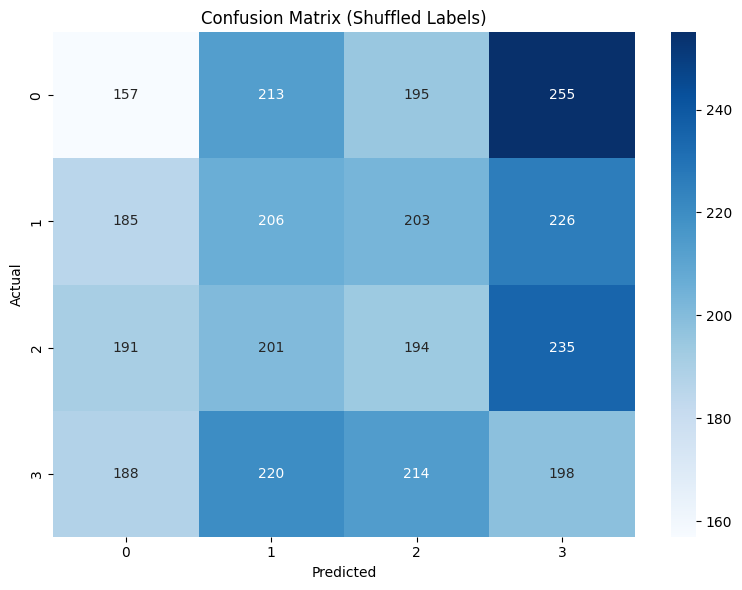

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import joblib

# --- Main Function ---
# Conducts a random label shuffling experiment to test if the model learns
# genuine patterns or memorizes noise (Section 6.10.5, p. 78).
# Loads data, preprocesses, shuffles labels, trains a model, and evaluates.
def main():
    # Load dataset (Section 6.4).
    df = pd.read_csv("rf_inputs.csv")

    # Encode categorical features (Section 6.4), handle missing values (Section 6.1).
    categorical_cols = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                        'np_deprel_pattern', 'head_number', 'source_file', 'nominal_head_upos']
    label_encoders = {col: LabelEncoder() for col in categorical_cols}
    for col in categorical_cols:
        df[col] = df[col].astype(str).fillna("unknown")
        df[col] = label_encoders[col].fit_transform(df[col])

    # Encode original target variables (needed for combined label).
    le_ezafe = LabelEncoder()
    df['ezafe_label'] = le_ezafe.fit_transform(df['ezafe_label'])

    # Create and encode combined label (Section 6.4).
    df['combined_label'] = df['ezafe_label'].astype(str) + "_" + df['position'].astype(str)
    le_combined = LabelEncoder()
    df['combined_label'] = le_combined.fit_transform(df['combined_label'])

    # Define features (X) and target (y) (Section 6.4).
    X = df.drop(columns=['nominal_head_id', 'nominal_head_form', 'dependent_id', 'dependent_form',
                         'ezafe_label', 'position', 'combined_label'])
    y = df['combined_label']

    # Ensure features are numeric, fill NaNs.
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')
            X[col] = X[col].fillna(-1)

    # Handle class imbalance (Section 6.5, Figure 22). Resamples data.
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # 🔀 Shuffle labels randomly. Breaks relationship between features and labels.
    # This is the core step of the random label shuffling experiment (Section 6.10.5).
    shuffled_y = pd.Series(y_resampled).sample(frac=1, random_state=42).reset_index(drop=True)

    # Split data for training the model on shuffled labels (Section 6.7 adaptation).
    # Stratify by shuffled labels to maintain their distribution in splits.
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, shuffled_y, test_size=0.2, random_state=42, stratify=shuffled_y
    )

    # Randomized Hyperparameter search (Section 6.6 adaptation).
    # Tunes model parameters on data with shuffled labels.
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', None] # Class weight used in original tuning (Section 6.6, 6.7).
    }

    random_search = RandomizedSearchCV(
        RandomForestClassifier(random_state=42),
        param_distributions=param_dist,
        n_iter=10, # Number of parameter settings sampled.
        cv=5, # Cross-validation folds.
        random_state=42
    )

    # Train model on shuffled labels using best params found by random search.
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    # Predict on test set with shuffled labels.
    y_pred = best_model.predict(X_test)

    # Evaluate performance using classification report.
    # Expected results: performance close to random guessing (Section 6.10.5).
    print("\n🔍 Evaluation Report (with randomly shuffled labels):\n")
    print(classification_report(y_test, y_pred, digits=4, zero_division='warn'))

    # Plot confusion matrix for visualization of performance with shuffled labels.
    # Expected: distribution of predictions close to uniform across classes.
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix (Shuffled Labels)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    joblib.dump(best_model, "rf_model_random_label_shuffle.pkl")

# --- Script Entry Point ---
if __name__ == "__main__":
    main()